In [ ]:
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import numpy as np
import gc


In [ ]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

In [ ]:
gc.collect()

38

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = model.to(device)
model = model.eval()

#Visualizations of protein 1A32 (mutation at position 10)

In [ ]:
import torch
import re
import numpy as np


# Define the wild-type sequence as a list of amino acids
sequence = "S P E V Q I A I L T E Q I N N L N E H L R V H K K D H H S R R G L L K M V G K R R R L L A Y L R N K D V A R Y R E I V E K L G"
residues = sequence.split()

# Define all amino acids (excluding the one already at position 10)
wildtype_aa = residues[9]
amino_acids = [aa for aa in "A R N D C Q E G H I L K M F P S T W Y V".split() if aa != wildtype_aa]

# Initialize a list to hold embeddings for all mutations
all_mutated_embeddings = []

# Function to get embeddings for a sequence
def get_embeddings(sequence):
    # Map rarely occurred amino acids (U,Z,O,B) to (X)
    sequence = re.sub(r"[UZOB]", "X", sequence)

    # Tokenize, encode the sequence, and load it into the GPU if possible
    ids = tokenizer.batch_encode_plus([sequence], add_special_tokens=True, padding=True)

    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    # Extract the sequence's features
    with torch.no_grad():
        embedding = model(input_ids=input_ids, attention_mask=attention_mask)

    embedding = embedding.last_hidden_state.cpu().numpy()

    # Remove padding and special tokens
    features = []
    for seq_num in range(len(embedding)):
        seq_len = (attention_mask[seq_num] == 1).sum()
        seq_emd = embedding[seq_num][:seq_len-1]
        features.append(seq_emd)

    return np.array(features)

# Get embedding for the wild-type sequence
wildtype_embedding = get_embeddings(sequence)

# Loop through all possible substitutions
for aa in amino_acids:
    mutated_residues = residues.copy()
    mutated_residues[9] = aa  # Mutate position 10 (index 9)
    mutated_sequence = " ".join(mutated_residues)

    # Get the embedding for the mutated sequence
    mutated_embedding = get_embeddings(mutated_sequence)

    # Store the result
    all_mutated_embeddings.append(mutated_embedding)

# Output all mutated embeddings
print(all_mutated_embeddings)


[array([[[ 0.10782177, -0.47884244,  0.37300727, ..., -0.13047202,
         -0.07280897,  0.20929003],
        [ 0.34559032, -0.05296079,  0.14334136, ...,  0.06171506,
          0.1475702 ,  0.3080618 ],
        [ 0.52233404, -0.37278867,  0.00725098, ...,  0.03774247,
         -0.18611352,  0.2483221 ],
        ...,
        [ 0.23864865,  0.13935629,  0.19446066, ..., -0.00758114,
         -0.08503415,  0.11668114],
        [ 0.15862934,  0.20646368,  0.08369362, ..., -0.08846718,
          0.18874955,  0.00365359],
        [-0.04887595, -0.08735265,  0.21080776, ..., -0.18670344,
         -0.01040124, -0.15896647]]], dtype=float32), array([[[ 9.47984308e-02, -4.82904613e-01,  3.89790893e-01, ...,
         -1.08050637e-01, -7.06435144e-02,  2.21336514e-01],
        [ 3.43260616e-01, -4.65530567e-02,  1.62173048e-01, ...,
          5.94589822e-02,  1.75679013e-01,  3.25773925e-01],
        [ 5.07371783e-01, -3.85948241e-01, -2.29389071e-02, ...,
          5.56280762e-02, -1.67447984e-

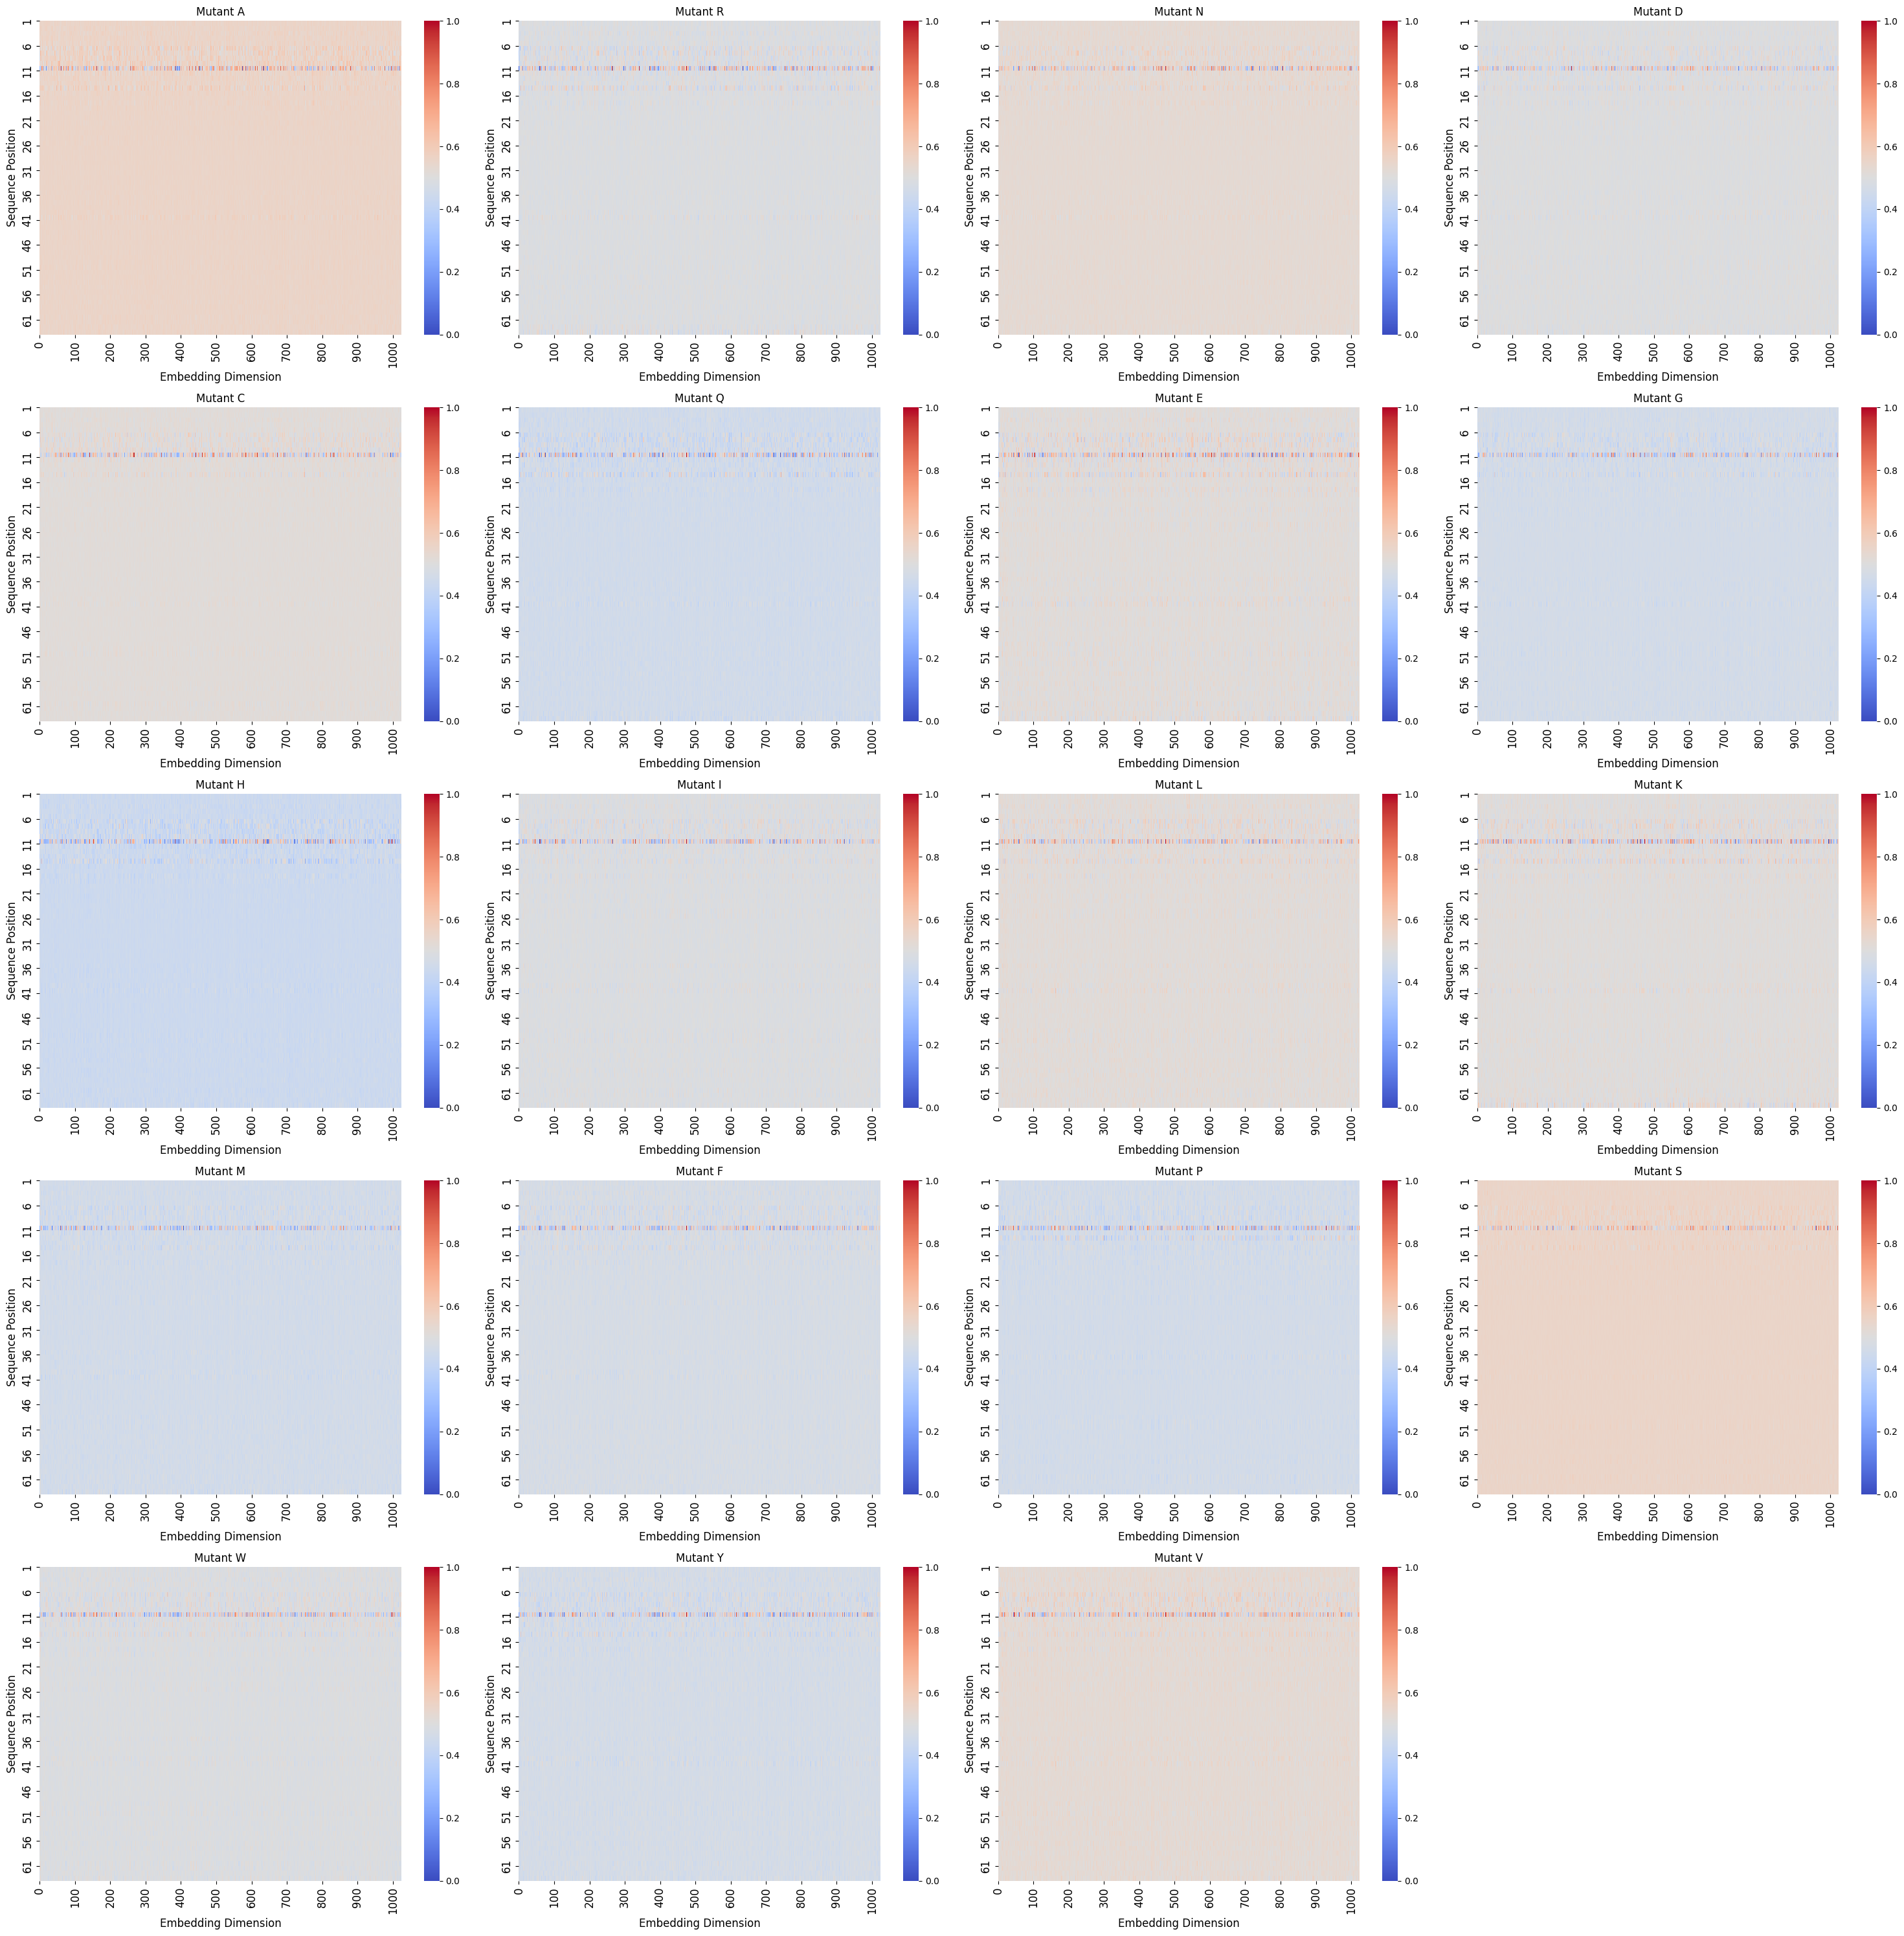

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the differences between each mutated embedding and the original embedding
embedding_differences = []
for mutated_embedding in all_mutated_embeddings:
    diff = mutated_embedding[0] - original_embedding[0]
    embedding_differences.append(diff)

# Convert to numpy array for easier handling
embedding_differences = np.array(embedding_differences)

# Plotting 19 normalized heatmaps (one for each mutated amino acid)
fig, axes = plt.subplots(5, 4, figsize=(30, 30))  # 5x4 grid
axes = axes.flatten()

# Customize font sizes
tick_fontsize = 12
label_fontsize = 12

for i, diff in enumerate(embedding_differences):
    ax = axes[i]

    # Normalize each heatmap individually using min-max scaling
    min_val = diff.min()
    max_val = diff.max()
    norm_diff = (diff - min_val) / (max_val - min_val + 1e-8)  # Add epsilon to avoid division by zero

    # Plot the heatmap
    sns.heatmap(norm_diff, cmap="coolwarm", ax=ax, cbar=True,
                xticklabels=10, yticklabels=10, cbar_kws={'label': ''},
                annot=False)

    ax.set_title(f"Mutant {amino_acids[i]}", fontsize=label_fontsize)
    ax.set_xlabel("Embedding Dimension", fontsize=label_fontsize)
    ax.set_ylabel("Sequence Position", fontsize=label_fontsize)

    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.set_yticks(np.arange(0, diff.shape[0], 5))
    ax.set_yticklabels(np.arange(1, diff.shape[0]+1, 5))
    ax.set_xticks(np.arange(0, diff.shape[1], 100))
    ax.set_xticklabels(np.arange(0, diff.shape[1], 100))

# Remove empty subplot
if len(amino_acids) < len(axes):
    for j in range(len(amino_acids), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


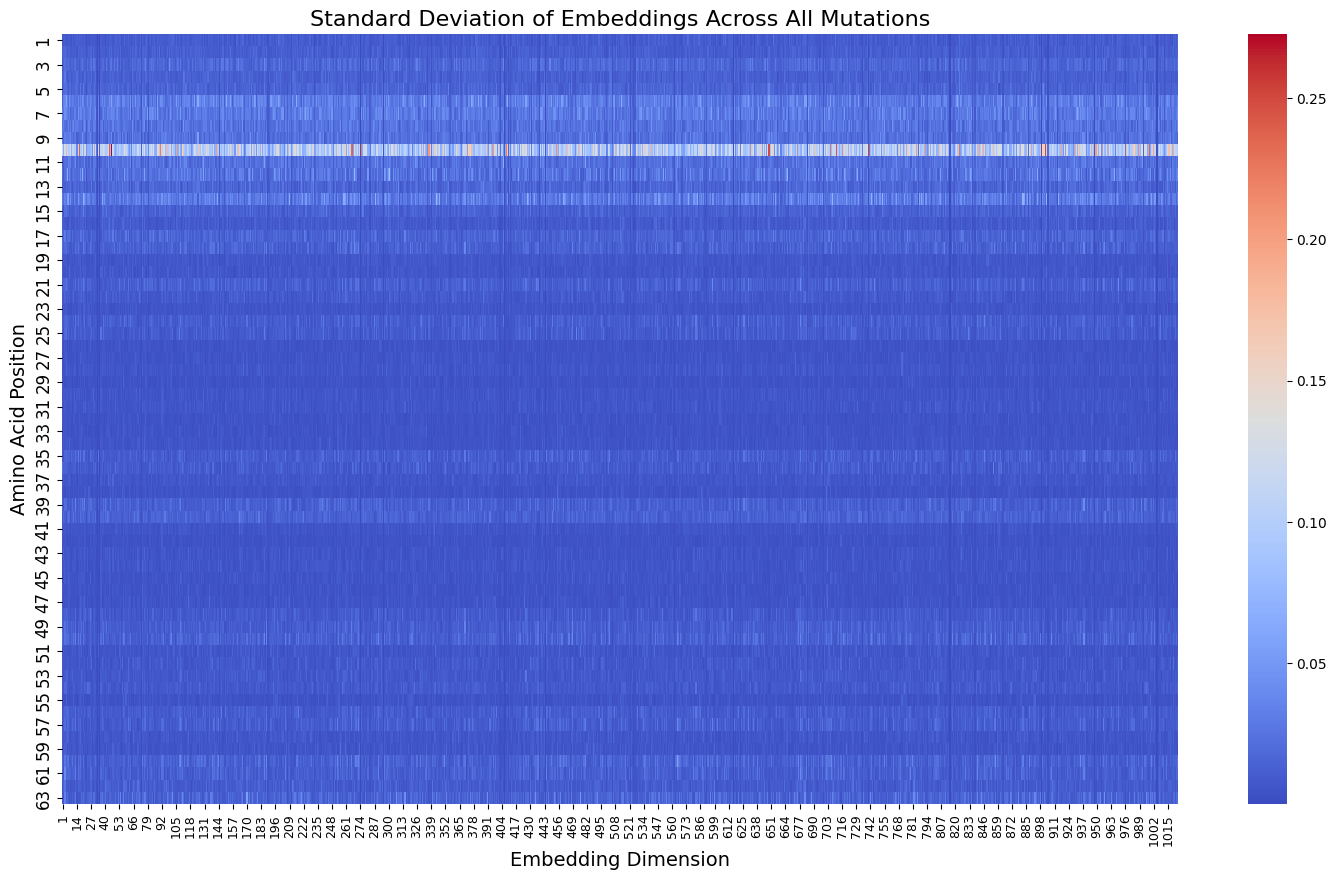

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Stack all embeddings along a new axis for mutation-wise std computation
all_feature_matrices = np.stack([features[0] for features in all_mutated_embeddings], axis=0)

# Compute standard deviation across mutations
std_deviation_matrix = np.std(all_feature_matrices, axis=0)  # Shape: (num_positions, num_embedding_dims)

# Plot the heatmap with an increased figure size
plt.figure(figsize=(18, 10))
ax = sns.heatmap(std_deviation_matrix, cmap="coolwarm", cbar=True, square=False)

# Get current ticks
xticks = ax.get_xticks()
yticks = ax.get_yticks()

# Shift tick labels to start from 1 instead of 0
ax.set_xticklabels([int(tick + 1) for tick in xticks], fontsize=9, rotation=90)
ax.set_yticklabels([int(tick + 1) for tick in yticks], fontsize=12)

# Improve axis labels
plt.title("Standard Deviation of Embeddings Across All Mutations", fontsize=16)
plt.xlabel("Embedding Dimension", fontsize=14)
plt.ylabel("Amino Acid Position", fontsize=14)

plt.show()


#Generate embeddins and find Top 3

In [ ]:

import torch
import re
import numpy as np

# Device setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device).eval()

# Original sequence
sequence = "D N L V I A L H S Y E P S H D G D L G F E K G E Q L R I L E Q S G E W W K A Q S L T T G Q E G F I P F N F V A K A"
sequence_list = sequence.split()


# Define all amino acids
amino_acids = "A C D E F G H I K L M N P Q R S T V W Y".split()

# Dictionary to store embeddings for mutations at each position
mutations_embeddings = {}

# Iterate over each position in the sequence
for pos in range(len(sequence_list)):
    original_residue = sequence_list[pos]  # The original amino acid at this position
    position_mutations = []  # List to store embeddings for this position

    # Loop through all possible amino acids
    for aa in amino_acids:
        if aa == original_residue:  # Skip if it's the same residue
            continue

        mutated_sequence_list = sequence_list.copy()  # Copy sequence list
        mutated_sequence_list[pos] = aa  # Replace current position with mutation

        # Convert back to string format
        mutated_sequence = " ".join(mutated_sequence_list)

        # Map rarely occurring amino acids (U,Z,O,B) to (X)
        mutated_sequence = re.sub(r"[UZOB]", "X", mutated_sequence)

        # Tokenize, encode the mutated sequence, and load it into the GPU if possible
        ids = tokenizer.batch_encode_plus([mutated_sequence], add_special_tokens=True, padding=True)

        input_ids = torch.tensor(ids['input_ids']).to(device)
        attention_mask = torch.tensor(ids['attention_mask']).to(device)

        # Extract the sequence's features and load it into the CPU if needed
        with torch.no_grad():
            embedding = model(input_ids=input_ids, attention_mask=attention_mask)

        embedding = embedding.last_hidden_state.cpu().numpy()

        # Remove padding (<pad>) and special tokens (</s>) added by the ProtT5-XL-UniRef50 model
        features = []
        for seq_num in range(len(embedding)):
            seq_len = (attention_mask[seq_num] == 1).sum()
            seq_emd = embedding[seq_num][:seq_len-1]  # Remove special tokens
            features.append(seq_emd)

        # Append the embeddings for the current mutation
        position_mutations.append((aa, features))

    # Store embeddings for all mutations at this position
    mutations_embeddings[pos + 1] = position_mutations  # Use 1-based indexing for positions

# Print results summary
for pos, mutations in mutations_embeddings.items():
    print(f"Position {pos}: {len(mutations)} mutations stored.")

print("All mutations processed!")



Position 1: 19 mutations stored.
Position 2: 19 mutations stored.
Position 3: 19 mutations stored.
Position 4: 19 mutations stored.
Position 5: 19 mutations stored.
Position 6: 19 mutations stored.
Position 7: 19 mutations stored.
Position 8: 19 mutations stored.
Position 9: 19 mutations stored.
Position 10: 19 mutations stored.
Position 11: 19 mutations stored.
Position 12: 19 mutations stored.
Position 13: 19 mutations stored.
Position 14: 19 mutations stored.
Position 15: 19 mutations stored.
Position 16: 19 mutations stored.
Position 17: 19 mutations stored.
Position 18: 19 mutations stored.
Position 19: 19 mutations stored.
Position 20: 19 mutations stored.
Position 21: 19 mutations stored.
Position 22: 19 mutations stored.
Position 23: 19 mutations stored.
Position 24: 19 mutations stored.
Position 25: 19 mutations stored.
Position 26: 19 mutations stored.
Position 27: 19 mutations stored.
Position 28: 19 mutations stored.
Position 29: 19 mutations stored.
Position 30: 19 mutatio

In [ ]:
# Function to get embeddings for a sequence
def get_embeddings(sequence):
    # Map rarely occurred amino acids (U,Z,O,B) to (X)
    sequence = re.sub(r"[UZOB]", "X", sequence)

    # Tokenize, encode the sequence, and load it into the GPU if possible
    ids = tokenizer.batch_encode_plus([sequence], add_special_tokens=True, padding=True)

    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    # Extract the sequence's features and load it into the CPU if needed
    with torch.no_grad():
        embedding = model(input_ids=input_ids, attention_mask=attention_mask)

    embedding = embedding.last_hidden_state.cpu().numpy()

    # Remove padding (<pad>) and special tokens (</s>) that are added by the ProtT5-XL-UniRef50 model
    features = []
    for seq_num in range(len(embedding)):
        seq_len = (attention_mask[seq_num] == 1).sum()
        seq_emd = embedding[seq_num][:seq_len-1]
        features.append(seq_emd)

    return np.array(features)

# Get the embeddings for the original (wild-type) sequence
original_embedding = get_embeddings(sequence)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Directory to save the heatmaps
save_dir = "mutation_individual_std_plots"
os.makedirs(save_dir, exist_ok=True)

# Get wild-type embedding
original_embedding = get_embeddings(sequence)  # shape: (1, seq_len, 1024)
original_embedding = original_embedding[0]     # shape: (seq_len, 1024)

# For each position
for pos, mutations in mutations_embeddings.items():
    for aa, features in mutations:
        mutant_embedding = features[0]  # shape: (seq_len, 1024)

        # Calculate absolute difference from wild-type
        diff = np.abs(mutant_embedding - original_embedding)  # shape: (seq_len, 1024)


In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Directory to save dimension trend plots
dim_trend_dir = "mutation_top3_std_trends"
os.makedirs(dim_trend_dir, exist_ok=True)

# For each mutation at each position
for pos, mutations in mutations_embeddings.items():
    for aa, features in mutations:
        mutant_embedding = features[0]  # shape: (seq_len, 1024)

        # Compute absolute difference from original
        diff = np.abs(mutant_embedding - original_embedding)  # shape: (seq_len, 1024)

        # Compute std for each embedding dimension across the sequence
        dim_std = np.std(diff, axis=0)  # shape: (1024,)

        # Get indices of top 3 most changing dimensions
        top_dims = np.argsort(dim_std)[-3:][::-1]  # Top 3 dims with highest std


In [ ]:
import pandas as pd
import numpy as np
import os

# Collect results here
rows = []

# For each mutation at each position
for pos, mutations in mutations_embeddings.items():
    for aa, features in mutations:
        mutant_embedding = features[0]  # shape: (seq_len, 1024)

        # Compute absolute difference from original
        diff = np.abs(mutant_embedding - original_embedding)  # shape: (seq_len, 1024)

        # Compute std for each embedding dimension across the sequence
        dim_std = np.std(diff, axis=0)  # shape: (1024,)

        # Get indices of top 3 most changing dimensions
        top_dims = np.argsort(dim_std)[-3:][::-1]  # Top 3 dims with highest std

        # Add to list
        rows.append({
            'Position': pos,  # Keep as 0-based or +1 if you prefer
            'Mutant': aa,
            'Top_3_Dimensions': top_dims.tolist()
        })

# Create DataFrame
df_top3_dims = pd.DataFrame(rows)

# Save to CSV
output_path = "top3_dims_from_diff.csv"
df_top3_dims.to_csv(output_path, index=False)

print(f"Saved top 3 changing dimensions to: {output_path}")


Saved top 3 changing dimensions to: top3_dims_from_diff.csv


In [ ]:
import pandas as pd

# Load both CSV files
df_features = pd.read_csv("top3_dims_from_diff.csv")  # File with position, Mutant, and Top_3_Dimensions
df_vmut_type = pd.read_csv("/content/drive/MyDrive/filtered_allowed_pdbs/1H92.csv") # File with vmut_type

# Filter out rows where the 'vmut_type' contains a colon
df_vmut_type = df_vmut_type[~df_vmut_type['mut_type'].str.contains(':')]

# Parse `vmut_type` into Position (numeric part) and Mutant
df_vmut_type['Position'] = df_vmut_type['mut_type'].str.extract(r'(\d+)', expand=False)
df_vmut_type['Mutant'] = df_vmut_type['mut_type'].str.extract(r'([A-Za-z]+)$', expand=False)

# Convert Position to numeric (handle cases where Position might not be numeric)
df_vmut_type['Position'] = pd.to_numeric(df_vmut_type['Position'], errors='coerce')


# Merge the two dataframes on Position and Mutant
df_merged = pd.merge(df_vmut_type, df_features, on=['Position', 'Mutant'], how='left')

# Save to a new CSV file
df_merged.to_csv("merged_with_dimension_features_1H92.csv", index=False)

print(df_merged.head())


   Unnamed: 0          name  \
0      205920  1H92.pdb_D1Q   
1      205921  1H92.pdb_D1E   
2      205922  1H92.pdb_D1N   
3      205923  1H92.pdb_D1H   
4      205924  1H92.pdb_D1R   

                                             dna_seq  log10_K50_t  \
0  TCTGCTGGCGGTTCCGCGGGTCAGAACCTGGTTATCGCGCTGCACT...     0.174292   
1  TCCGCTGGCGGTTCTGCGGGTGAAAACCTGGTTATCGCGCTGCACT...     0.397442   
2  TCCGCGGGTGGCTCTGCGGGCAACAACCTGGTTATCGCGCTGCACT...     0.216884   
3  TCCGCTGGCGGTTCCGCGGGTCACAACCTGGTTATCGCGCTGCACT...     0.286886   
4  TCTGCGGGTGGTTCCGCGGGTCGTAACCTGGTTATCGCGCTCCACT...    -0.161749   

   log10_K50_t_95CI_high  log10_K50_t_95CI_low  log10_K50_t_95CI  \
0               0.186152              0.162402          0.023750   
1               0.411948              0.373914          0.038035   
2               0.236459              0.190466          0.045993   
3               0.308411              0.277046          0.031365   
4              -0.153032             -0.183320          0.

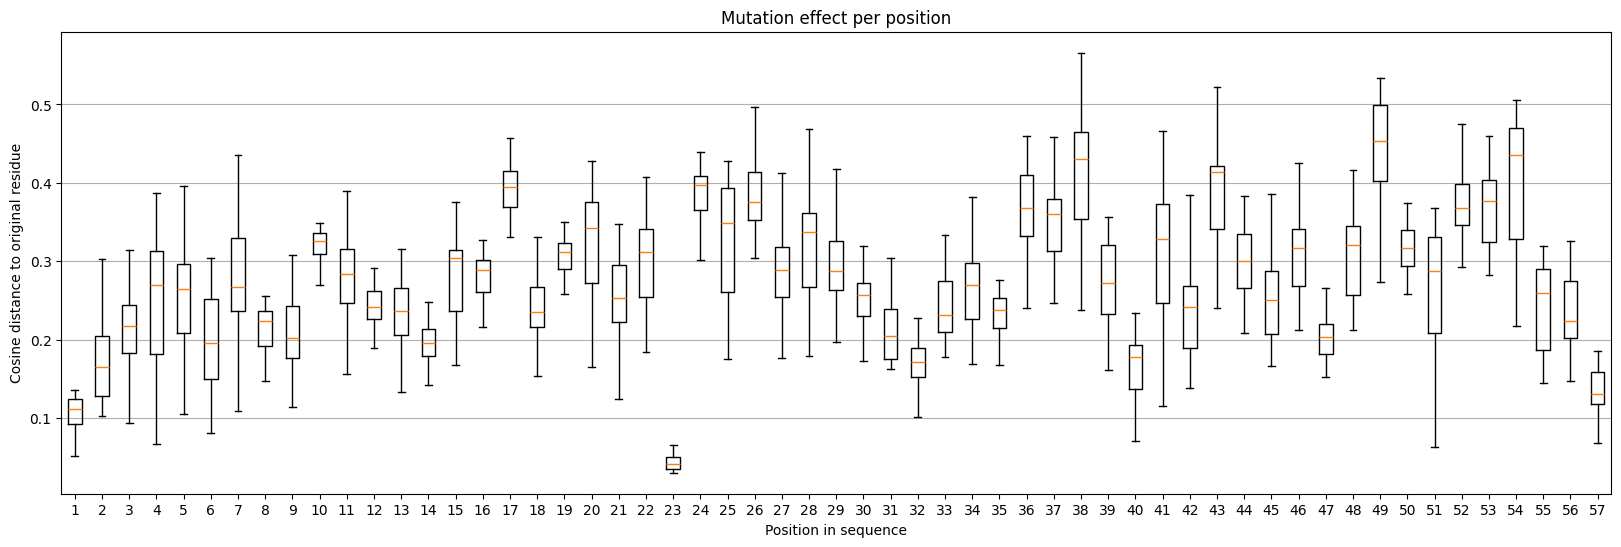

   Position  Cosine_Distance
0         1         0.088199
1         1         0.173947
2         1         0.051896
3         1         0.135932
4         1         0.095931


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine

# Collect distances for each position
position_distances = {}

# Loop over all positions
for pos, mutations in mutations_embeddings.items():
    distances = []

    for (aa, features) in mutations:
        mutation_embedding = features[0]  # shape: (sequence_length, embedding_dim)

        # Get embedding at this position (index = pos-1 because your dictionary is 1-indexed)
        mutation_vector = mutation_embedding[pos - 1]
        original_vector = original_embedding[pos - 1]

        # Compute cosine distance (or Euclidean norm)
        distance = cosine(mutation_vector, original_vector)
        distances.append(distance)

    position_distances[pos] = distances

# Plotting
plt.figure(figsize=(20, 6))
positions = sorted(position_distances.keys())
data = [position_distances[pos] for pos in positions]

plt.boxplot(data, positions=positions, showfliers=False)
plt.xlabel("Position in sequence")
plt.ylabel("Cosine distance to original residue")
plt.title("Mutation effect per position")
plt.xticks(ticks=positions)
plt.grid(True, axis='y')
plt.show()

# ✅ Save to CSV
# First, prepare a flattened DataFrame
rows = []
for pos, dist_list in position_distances.items():
    for dist in dist_list:
        rows.append({
            'Position': pos,
            'Cosine_Distance': dist
        })

df_distances = pd.DataFrame(rows)

# Save to CSV
df_distances.to_csv("mutation_cosine_distances_1H92.csv", index=False)

# Optional: Check what you saved
print(df_distances.head())


In [ ]:
import numpy as np
import pandas as pd

# Length of the sequence
sequence_length = original_embedding.shape[0]

# Prepare a list to collect all Q1 and Q3 profiles
all_q_profiles = []

# Iterate over each mutated position
for mutated_pos, mutations in sorted(mutations_embeddings.items()):
    all_embeddings = []

    for (aa, features) in mutations:
        mutation_embedding = features[0]  # shape: (sequence_length, embedding_dim)
        all_embeddings.append(mutation_embedding)

    all_embeddings = np.stack(all_embeddings, axis=0)  # shape: (num_mutations, sequence_length, embedding_dim)

    q1_profile = []
    q3_profile = []
    residue_positions = list(range(1, sequence_length + 1))  # 1-based indexing for residues

    # For each residue position along the sequence
    for res_pos in range(sequence_length):
        vectors_at_residue = all_embeddings[:, res_pos, :]  # shape: (num_mutations, embedding_dim)

        q1 = np.percentile(vectors_at_residue, 25, axis=0)  # (embedding_dim,)
        q3 = np.percentile(vectors_at_residue, 75, axis=0)  # (embedding_dim,)

        # Mean Q1/Q3 across embedding dimensions
        q1_mean = np.mean(q1)
        q3_mean = np.mean(q3)

        q1_profile.append(q1_mean)
        q3_profile.append(q3_mean)

    # Save the Q1/Q3 profile for this mutated position into a DataFrame
    df_profile = pd.DataFrame({
        'Mutated_Position': mutated_pos,
        'Residue_Position': residue_positions,
        'Q1': q1_profile,
        'Q3': q3_profile
    })
    all_q_profiles.append(df_profile)

# After all mutated positions are processed, concatenate everything
final_df = pd.concat(all_q_profiles, ignore_index=True)

# Save to CSV
final_df.to_csv("quantile_profiles_per_mutated_position_1H92.csv", index=False)

print(final_df.head())


   Mutated_Position  Residue_Position        Q1        Q3
0                 1                 1 -0.051036  0.036193
1                 1                 2 -0.028977  0.016661
2                 1                 3 -0.019491  0.009976
3                 1                 4  0.005227  0.022135
4                 1                 5 -0.004320  0.014713


In [ ]:
from google.colab import files
files.download("merged_with_dimension_features_1H92.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("mutation_cosine_distances_1H92.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("quantile_profiles_per_mutated_position_1H92.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#50 TOP,RANDOM AND LEAST embeddings

In [ ]:
import os
import pandas as pd
import ast
from collections import Counter

top_dims_counter = Counter()
csv_dir = "/content/drive/MyDrive/TOP3DIMENSION"

# Iterate over all CSV files and collect dimension counts
for file in os.listdir(csv_dir):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(csv_dir, file))
        df = df.dropna(subset=["Top_3_Dimensions"])

        for dims in df["Top_3_Dimensions"]:
            try:
                dims_list = ast.literal_eval(dims)
                if isinstance(dims_list, list):
                    top_dims_counter.update(dims_list)
            except Exception as e:
                print(f"Skipping row due to error: {e}")

# Get the 50 most common dimensions
top_50_dims = [dim for dim, _ in top_dims_counter.most_common(50)]

print(" Top 50 most frequent dimensions:")
print(top_50_dims)


✅ Top 100 most frequent dimensions:
[407, 648, 15, 710, 823, 45, 104, 1018, 453, 791, 394, 988, 997, 336, 948, 213, 266, 373, 740, 1015, 90, 916, 958, 1001, 984, 154, 111, 161, 654, 840, 265, 722, 539, 89, 408, 87, 1020, 182, 853, 274, 806, 159, 977, 332, 1008, 254, 4, 389, 634, 768, 669, 197, 531, 337, 897, 351, 138, 955, 349, 902, 385, 270, 141, 449, 601, 968, 160, 546, 370, 757, 361, 860, 960, 738, 297, 737, 632, 621, 755, 705, 645, 752, 982, 965, 983, 514, 17, 533, 483, 341, 83, 350, 861, 868, 693, 16, 125, 415, 501, 782]


In [ ]:
import torch
import re
import numpy as np

# Selected dimensions to extract
selected_dims = [407, 648, 15, 710, 823, 45, 104, 1018, 453, 791, 394, 988, 997, 336, 948, 213, 266, 373, 740, 1015,
                 90, 916, 958, 1001, 984, 154, 111, 161, 654, 840, 265, 722, 539, 89, 408, 87, 1020, 182, 853, 274,
                 806, 159, 977, 332, 254, 1008, 4, 389, 634, 768]

# Device setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device).eval()

# Function to get embeddings for a sequence and extract only selected dimensions
def get_selected_embeddings(sequence):
    sequence = re.sub(r"[UZOB]", "X", sequence)
    ids = tokenizer.batch_encode_plus([sequence], add_special_tokens=True, padding=True)

    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    with torch.no_grad():
        embedding = model(input_ids=input_ids, attention_mask=attention_mask)

    embedding = embedding.last_hidden_state.cpu().numpy()
    features = []
    for seq_num in range(len(embedding)):
        seq_len = (attention_mask[seq_num] == 1).sum()
        seq_emd = embedding[seq_num][:seq_len-1]
        # Extract only the selected dimensions
        seq_selected = seq_emd[:, selected_dims]
        features.append(seq_selected)

    return np.array(features)

# Original sequence
sequence = "K S A V K A L F D Y K A Q R E D E L T F T K S A I I Q N V E K Q D G G W W R G D Y G G K K Q L W F P S N Y V E E M I"
sequence_list = sequence.split()
amino_acids = "A C D E F G H I K L M N P Q R S T V W Y".split()

mutations_embeddings = {}

# Iterate over each position
for pos in range(len(sequence_list)):
    original_residue = sequence_list[pos]
    position_mutations = []

    for aa in amino_acids:
        if aa == original_residue:
            continue

        mutated_sequence_list = sequence_list.copy()
        mutated_sequence_list[pos] = aa
        mutated_sequence = " ".join(mutated_sequence_list)

        selected_features = get_selected_embeddings(mutated_sequence)
        position_mutations.append((aa, selected_features))

    mutations_embeddings[pos + 1] = position_mutations
# Get and save the selected embeddings for the wild-type (original) sequence
original_selected_embedding = get_selected_embeddings(sequence)

# Save it separately for clarity
with open("/content/drive/MyDrive/original_selected_embeddings/1Y0M_wildtype_selected_embedding.npy", "wb") as f:
    np.save(f, original_selected_embedding)

print("Wild-type embedding saved!")

# Save the results
import pickle
with open("/content/drive/MyDrive/mutations_selected_embeddings/1Y0M_mutations_selected_embeddings.pkl", "wb") as f:
    pickle.dump(mutations_embeddings, f)

print("All mutations processed and saved with selected dimensions!")


In [ ]:
import torch
import re
import numpy as np

# Selected dimensions to extract
selected_dims = [853, 50, 189, 296, 859, 476, 61, 751, 512, 990, 585, 31, 938, 304, 605, 344, 35, 477, 963, 666,
 1005, 872, 280, 942, 206, 28, 919, 396, 736, 179, 424, 676, 279, 538, 232, 292, 186, 901, 192, 9,
 30, 144, 539, 213, 1013, 765, 447, 649, 113, 875]


# Device setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device).eval()

# Function to get embeddings for a sequence and extract only selected dimensions
def get_selected_embeddings(sequence):
    sequence = re.sub(r"[UZOB]", "X", sequence)
    ids = tokenizer.batch_encode_plus([sequence], add_special_tokens=True, padding=True)

    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    with torch.no_grad():
        embedding = model(input_ids=input_ids, attention_mask=attention_mask)

    embedding = embedding.last_hidden_state.cpu().numpy()
    features = []
    for seq_num in range(len(embedding)):
        seq_len = (attention_mask[seq_num] == 1).sum()
        seq_emd = embedding[seq_num][:seq_len-1]
        # Extract only the selected dimensions
        seq_selected = seq_emd[:, selected_dims]
        features.append(seq_selected)

    return np.array(features)

# Original sequence
sequence = "G S P G L P S G W E E R K D A K G R T Y Y V N H N N R T T T W T R P I M"
sequence_list = sequence.split()
amino_acids = "A C D E F G H I K L M N P Q R S T V W Y".split()

mutations_embeddings = {}

# Iterate over each position
for pos in range(len(sequence_list)):
    original_residue = sequence_list[pos]
    position_mutations = []

    for aa in amino_acids:
        if aa == original_residue:
            continue

        mutated_sequence_list = sequence_list.copy()
        mutated_sequence_list[pos] = aa
        mutated_sequence = " ".join(mutated_sequence_list)

        selected_features = get_selected_embeddings(mutated_sequence)
        position_mutations.append((aa, selected_features))

    mutations_embeddings[pos + 1] = position_mutations
# Get and save the selected embeddings for the wild-type (original) sequence
original_selected_embedding = get_selected_embeddings(sequence)

# Save it separately for clarity
with open("/content/drive/MyDrive/original_random_embeddings/1WR4_wildtype_random_embedding.npy", "wb") as f:
    np.save(f, original_selected_embedding)

print("Wild-type embedding saved!")

# Save the results
import pickle
with open("/content/drive/MyDrive/mutations_random_embeddings/1WR4_mutations_random_embeddings.pkl", "wb") as f:
    pickle.dump(mutations_embeddings, f)

print("All mutations processed and saved with selected dimensions!")


Wild-type embedding saved!
All mutations processed and saved with selected dimensions!


In [ ]:
import torch
import re
import numpy as np

# Selected dimensions to extract
selected_dims = [31, 32, 34, 35, 72, 144, 273, 294, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,
     437, 443, 524, 561, 615, 683, 734, 739, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820,
     862, 886, 898, 947, 966, 975, 1004]



# Device setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device).eval()

# Function to get embeddings for a sequence and extract only selected dimensions
def get_selected_embeddings(sequence):
    sequence = re.sub(r"[UZOB]", "X", sequence)
    ids = tokenizer.batch_encode_plus([sequence], add_special_tokens=True, padding=True)

    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    with torch.no_grad():
        embedding = model(input_ids=input_ids, attention_mask=attention_mask)

    embedding = embedding.last_hidden_state.cpu().numpy()
    features = []
    for seq_num in range(len(embedding)):
        seq_len = (attention_mask[seq_num] == 1).sum()
        seq_emd = embedding[seq_num][:seq_len-1]
        # Extract only the selected dimensions
        seq_selected = seq_emd[:, selected_dims]
        features.append(seq_selected)

    return np.array(features)

# Original sequence
sequence = "G S P G L P S G W E E R K D A K G R T Y Y V N H N N R T T T W T R P I M"
sequence_list = sequence.split()
amino_acids = "A C D E F G H I K L M N P Q R S T V W Y".split()

mutations_embeddings = {}

# Iterate over each position
for pos in range(len(sequence_list)):
    original_residue = sequence_list[pos]
    position_mutations = []

    for aa in amino_acids:
        if aa == original_residue:
            continue

        mutated_sequence_list = sequence_list.copy()
        mutated_sequence_list[pos] = aa
        mutated_sequence = " ".join(mutated_sequence_list)

        selected_features = get_selected_embeddings(mutated_sequence)
        position_mutations.append((aa, selected_features))

    mutations_embeddings[pos + 1] = position_mutations
# Get and save the selected embeddings for the wild-type (original) sequence
original_selected_embedding = get_selected_embeddings(sequence)

# Save it separately for clarity
with open("/content/drive/MyDrive/original_least_embeddings/1WR4_wildtype_least_embedding.npy", "wb") as f:
    np.save(f, original_selected_embedding)

print("Wild-type embedding saved!")

# Save the results
import pickle
with open("/content/drive/MyDrive/mutations_least_embeddings/1WR4_mutations_least_embeddings.pkl", "wb") as f:
    pickle.dump(mutations_embeddings, f)

print("All mutations processed and saved with selected dimensions!")


AttributeError: 'XGBRegressor' object has no attribute 'to'

In [ ]:
import torch
import re
import numpy as np
import pickle

# Device setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device).eval()

# Function to get embeddings for a sequence and apply max pooling (top-50)
def get_maxpooled_embeddings(sequence, top_k=50):
    sequence = re.sub(r"[UZOB]", "X", sequence)
    ids = tokenizer.batch_encode_plus([sequence], add_special_tokens=True, padding=True)

    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    with torch.no_grad():
        embedding = model(input_ids=input_ids, attention_mask=attention_mask)

    embedding = embedding.last_hidden_state.cpu().numpy()  # (1, seq_len, 1024)
    features = []

    for seq_num in range(len(embedding)):
        seq_len = (attention_mask[seq_num] == 1).sum()
        seq_emd = embedding[seq_num][:seq_len-1]  # remove [CLS] and [SEP]
        # Max pooling: take top-k values from each row (L, 1024) → (L, 50)
        seq_pooled = -np.sort(-seq_emd, axis=1)[:, :top_k]
        features.append(seq_pooled)

    return np.array(features)  # shape: (1, L, 50)

# Original sequence
sequence = "R P M N A F M V W A R I H R P A L A K A N P A A N N A E I S V Q L G L E W N K L S E E Q K K P Y Y D E A Q K I K E"
sequence_list = sequence.split()
amino_acids = "A C D E F G H I K L M N P Q R S T V W Y".split()

mutations_embeddings = {}

# Process mutations
for pos in range(len(sequence_list)):
    original_residue = sequence_list[pos]
    position_mutations = []

    for aa in amino_acids:
        if aa == original_residue:
            continue

        mutated_sequence_list = sequence_list.copy()
        mutated_sequence_list[pos] = aa
        mutated_sequence = " ".join(mutated_sequence_list)

        pooled_features = get_maxpooled_embeddings(mutated_sequence)  # (1, L, 50)
        position_mutations.append((aa, pooled_features))

    mutations_embeddings[pos + 1] = position_mutations

# Get and save wild-type embedding
original_maxpooled_embedding = get_maxpooled_embeddings(sequence)

with open("/content/drive/MyDrive/1A32_wildtype_maxpool_embedding.npy", "wb") as f:
    np.save(f, original_maxpooled_embedding)

print(" Wild-type embedding saved!")

# Save mutation embeddings
with open("/content/drive/MyDrive/1A32_mutations_maxpool_embeddings.pkl", "wb") as f:
    pickle.dump(mutations_embeddings, f)

print("All mutations processed and saved with max pooling!")




✅ Wild-type embedding saved!
✅ All mutations processed and saved with max pooling!


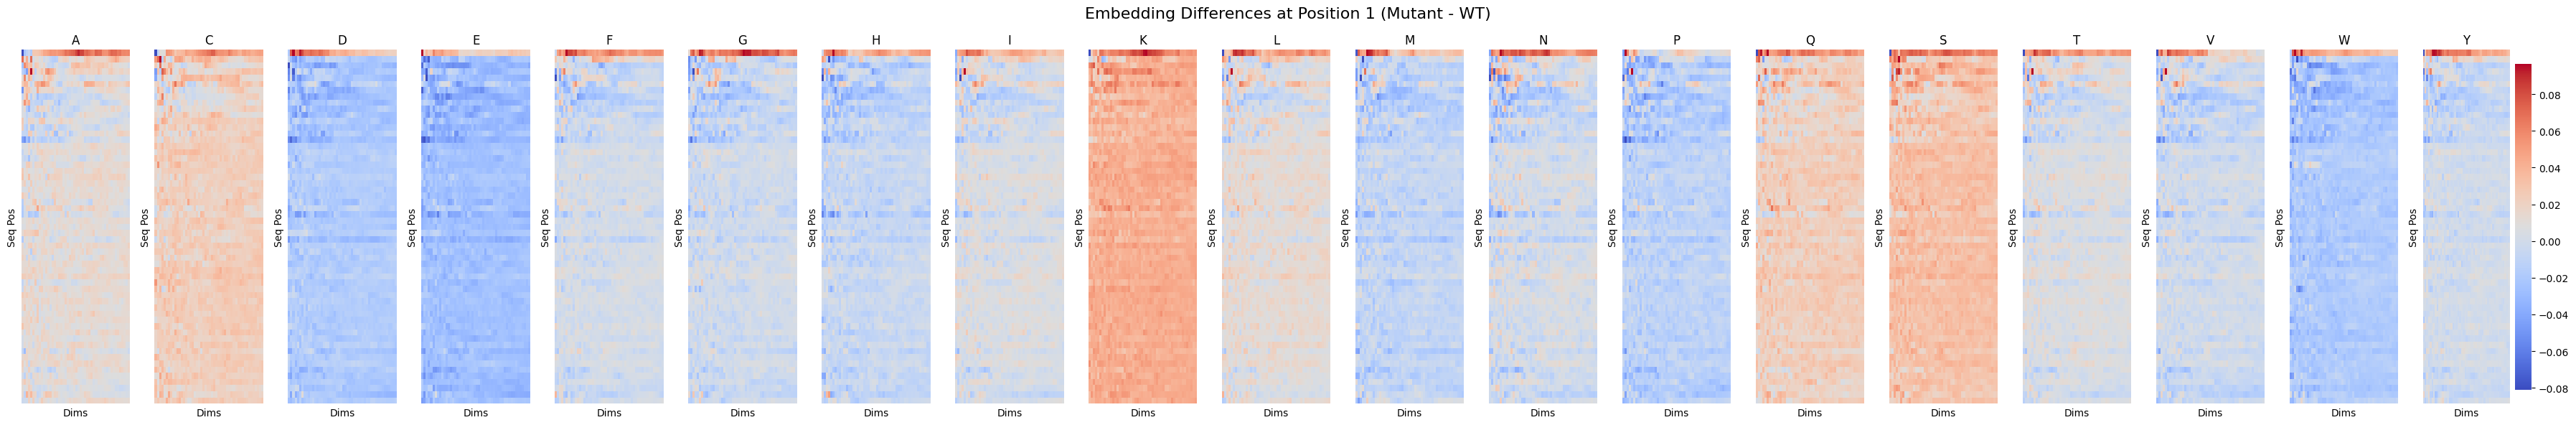

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load mutated and wild-type embeddings
with open("/content/drive/MyDrive/1A32_mutations_maxpool_embeddings.pkl", "rb") as f:
    mutations_embeddings = pickle.load(f)

original_embedding = np.load("/content/drive/MyDrive/1A32_wildtype_maxpool_embedding.npy")  # shape: (1, L, 50)
wildtype = original_embedding[0]  # shape: (L, 50)

# Amino acid list (for mutation labels)
amino_acids = "A C D E F G H I K L M N P Q R S T V W Y".split()

# Focus on position 1 (1-based → index 0)
position = 1
mutations_at_pos = mutations_embeddings[position]  # list of 19 (aa, (1, L, 50))

# Compute differences
embedding_differences = []
aa_labels = []

for aa, mutant_embedding in mutations_at_pos:
    mutant = mutant_embedding[0]  # shape: (L, 50)
    diff = mutant - wildtype  # shape: (L, 50)
    embedding_differences.append(diff)
    aa_labels.append(aa)

embedding_differences = np.array(embedding_differences)  # shape: (19, L, 50)

# Plot: 19 heatmaps (one for each mutation at position 1)
fig, axes = plt.subplots(1, 19, figsize=(36, 6))
axes = axes.flatten()

for i in range(19):
    sns.heatmap(
        embedding_differences[i],
        cmap="coolwarm",
        ax=axes[i],
        cbar=(i == 18),
        xticklabels=False,
        yticklabels=False,
    )
    axes[i].set_title(f"{aa_labels[i]}", fontsize=12)
    axes[i].set_xlabel("Dims")
    axes[i].set_ylabel("Seq Pos")

plt.suptitle("Embedding Differences at Position 1 (Mutant - WT)", fontsize=16)
plt.tight_layout()
plt.show()


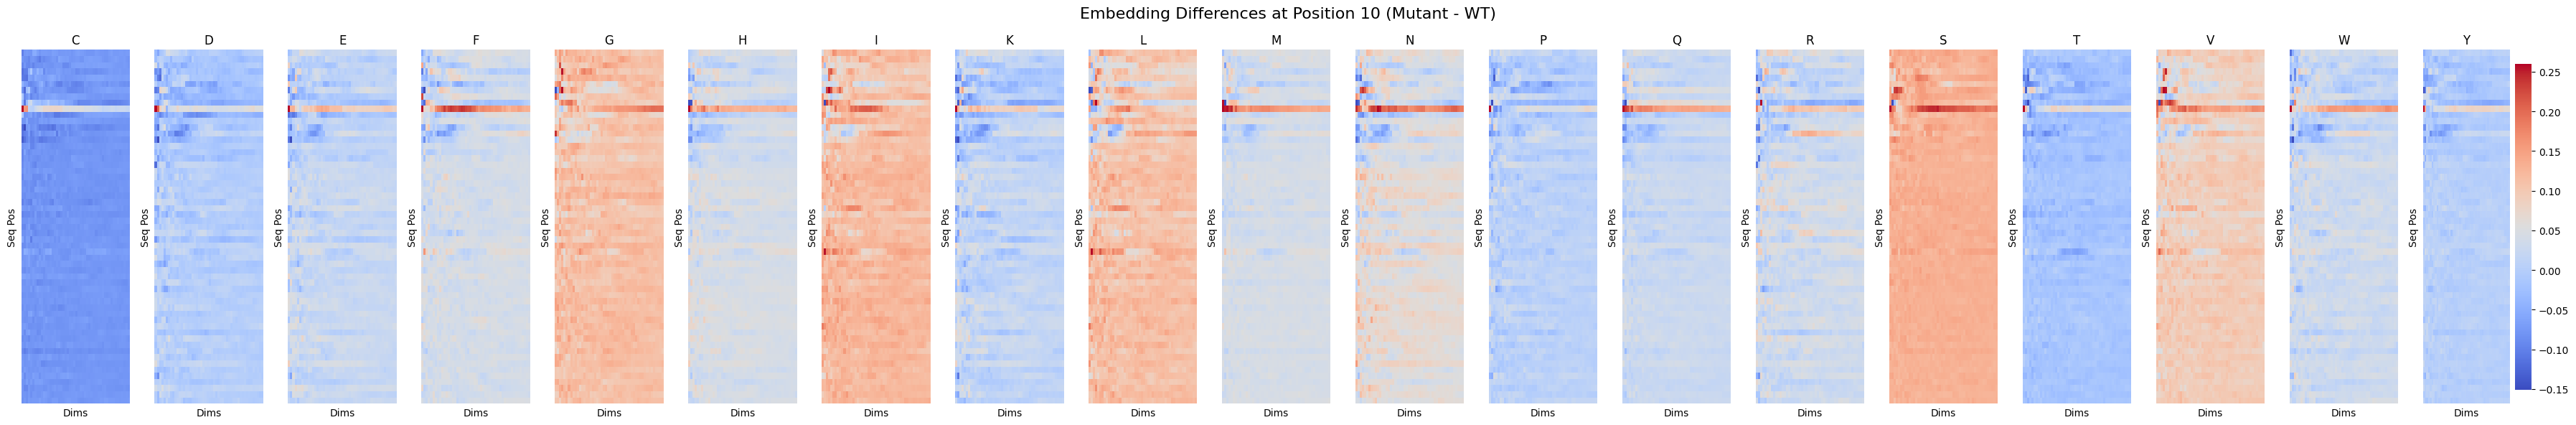

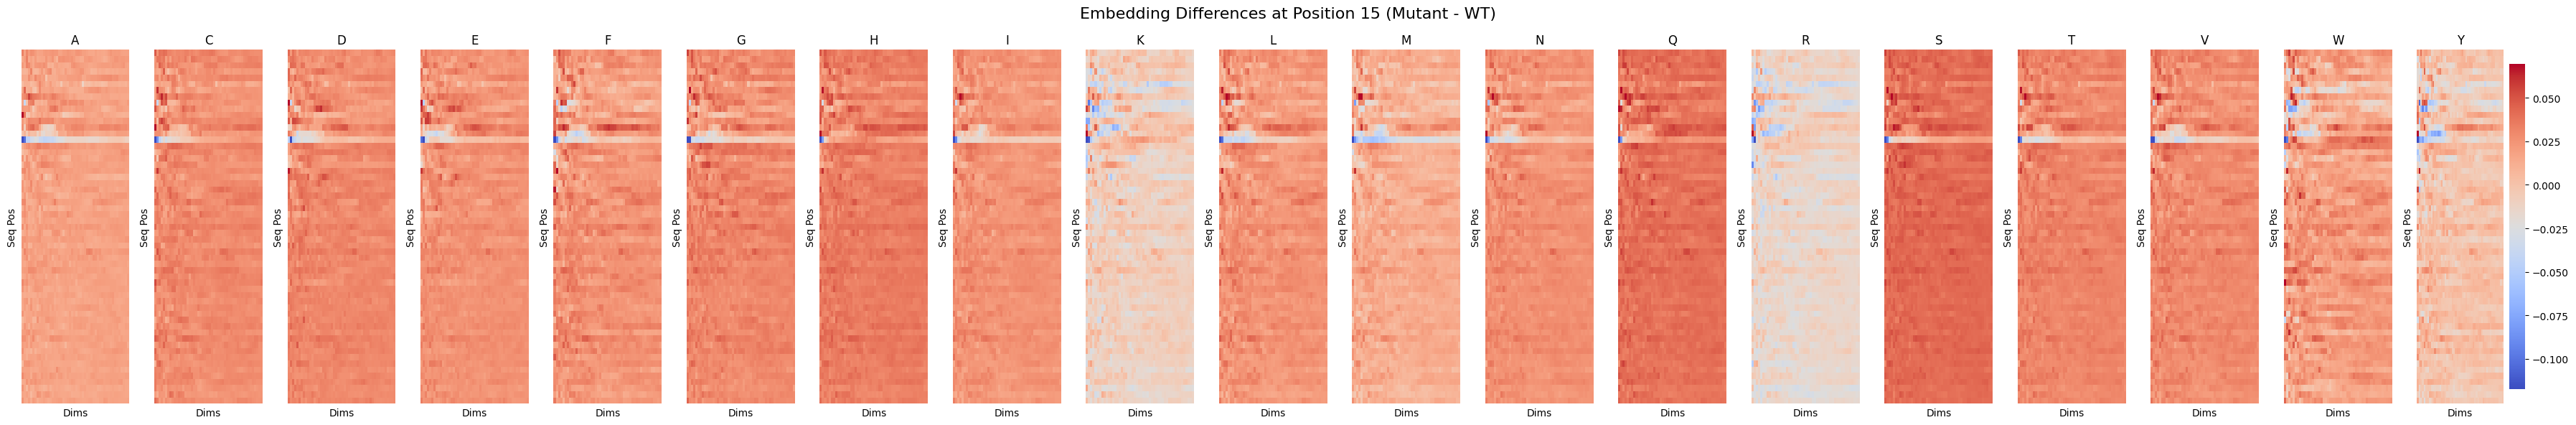

In [ ]:

# Amino acids
amino_acids = "A C D E F G H I K L M N P Q R S T V W Y".split()

# Define which positions you want (1-based → subtract 1)
positions_to_plot = [10, 15]

for pos in positions_to_plot:
    index = pos  # Dictionary key is 1-based (no subtraction)
    if index not in mutations_embeddings:
        print(f"Position {pos} not found in mutations dict.")
        continue

    mutants = mutations_embeddings[index]  # [(aa, embedding)]
    diffs = []
    labels = []

    for aa, mut_emb in mutants:
        diff = mut_emb[0] - wildtype  # (L, 50)
        diffs.append(diff)
        labels.append(aa)

    diffs = np.array(diffs)  # (19, L, 50)

    # Plot all 19 mutant diffs for this position
    fig, axes = plt.subplots(1, 19, figsize=(36, 6))
    axes = axes.flatten()

    for i in range(19):
        sns.heatmap(
            diffs[i],
            cmap="coolwarm",
            ax=axes[i],
            cbar=(i == 18),
            xticklabels=False,
            yticklabels=False,
        )
        axes[i].set_title(f"{labels[i]}", fontsize=12)
        axes[i].set_xlabel("Dims")
        axes[i].set_ylabel("Seq Pos")

    plt.suptitle(f"Embedding Differences at Position {pos} (Mutant - WT)", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import pandas as pd
import re
import numpy as np
import pickle
from tqdm import tqdm

# === Setup ===
df = pd.read_csv("/content/drive/MyDrive/wt_sequences.csv")

assert "pdb_name" in df.columns and "WT_sequence" in df.columns, "Missing required columns!"

# 166 proteins list
target_pdbs = ['3I35', '1UFM', '2M8I', '5AHT', '2QFF', '2MW9', '2LC2', '2N88', '2CJJ', '2L9R', '2BTH', '4UZW', '1ENH',
               '2MI6', '2LYR', '2M2L', '1TUD', '5Z2S', '4C26', '2WXC', '3L1X', '1UZC', '5UCE', '2MXD', '2AMI', '5LXJ',
               '1PV0', '2MKY', '2LHC', '1VII', '2K2A', '2JZ2', '2GP8', '2L2D', '2OP7', '2WQG', '1IFY', '2K1B', '3ZGK',
               '2JVD', '2WNM', '2D1U', '1YP5', '2L7F', '3MYC', '7JJK', '1V1C', '2N4R', '2LYQ', '2L7M', '1PWT', '1Y0M',
               '1AOY', '1ORC', '1TUC', '2M8U', '1WCL', '2JTV', '2KVT', '2KCF', '2B89', '6FVC', '2LVN', '1GL5', '2EXD',
               '1YU5', '1LP1', '2KFV', '2BTT', '6EWU', '1GYZ', '2LO1', '3V1A', '4G3O', '2JWT', '2MYX', '2M9F', '5VNT',
               '1JIC', '2LHR', '1I2T', '2RRU', '1W4H', '2MWB', '2K5P', '2RJV', '4HCK', '1QLY', '1ZHC', '1R69', '1F0M',
               '1TG0', '6SCW', '2L2P', '1QP2', '2K9D', '6IWS', '2M2J', '2M6Y', '2JT1', '2CDT', '2KVS', '2YSB', '2JVG',
               '3CQT', '2KGT', '2LGW', '6ACV', '1GJS', '2OCH', '1K1V', '2M0C', '6EWT', '2JN4', '1WR4', '1ZLM', '2LP5',
               '6SOW', '2JWS', '1I6C', '2M9E', '1E0L', '2L6Q', '2YSF', '2LCL', '2M0Y', '1PSE', '2RRT', '1W4G', '2MWA',
               '2L33', '1URF', '5JRT', '2L09', '2KRU', '2M9I', '6NMW', '2K28', '2KWH', '2KCM', '2MA4', '1YRF', '1SRM',
               '2M8J', '2KXD', '1E6H', '2LJ3', '2LUM', '6EWS', '5UBS', '2MH8', '2KR3', '2LQK', '2RU9', '2M8E', '1W4F',
               '2K5N', '1QKH', '3DKM', '1H92', '2KZJ', '5OAO', '1QKX', '1A32', '2O2W', '1O6X']

df_filtered = df[df["pdb_name"].isin(target_pdbs)]

amino_acids = "A C D E F G H I K L M N P Q R S T V W Y".split()

# Model setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device).eval()

# Max-pooling function
def get_maxpooled_embeddings(sequence, top_k=50):
    sequence = re.sub(r"[UZOB]", "X", sequence)
    ids = tokenizer.batch_encode_plus([sequence], add_special_tokens=True, padding=True)
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    with torch.no_grad():
        embedding = model(input_ids=input_ids, attention_mask=attention_mask)
    embedding = embedding.last_hidden_state.cpu().numpy()

    features = []
    for seq_num in range(len(embedding)):
        seq_len = (attention_mask[seq_num] == 1).sum()
        seq_emd = embedding[seq_num][:seq_len - 1]  # (L, 1024)
        pooled = -np.sort(-seq_emd, axis=1)[:, :top_k]  # (L, 50)
        features.append(pooled)

    return np.array(features)  # (1, L, 50)

# === Process each protein ===
for _, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    pdb_name = row["pdb_name"]
    sequence = row["WT_sequence"].strip()
    sequence_list = sequence.split()
    L = len(sequence_list)

    try:
        # Wild-type embedding
        wt_embedding = get_maxpooled_embeddings(sequence)

        # Mutations
        mutations_embeddings = {}
        for pos in range(L):
            original_aa = sequence_list[pos]
            mutants = []

            for aa in amino_acids:
                if aa == original_aa:
                    continue
                mutated = sequence_list.copy()
                mutated[pos] = aa
                mutated_seq = " ".join(mutated)
                emb = get_maxpooled_embeddings(mutated_seq)
                mutants.append((aa, emb))

            mutations_embeddings[pos + 1] = mutants

        # Save
        with open(f"/content/drive/MyDrive/embedding_data/max/mutations/{pdb_name}_mutations_maxpool_embeddings.pkl", "wb") as f:
            pickle.dump(mutations_embeddings, f)

        np.save(f"/content/drive/MyDrive/embedding_data/max/original/{pdb_name}_wildtype_maxpool_embedding.npy", wt_embedding)

    except Exception as e:
        print(f"Failed for {pdb_name}: {e}")

print("All proteins processed and saved.")


100%|██████████| 166/166 [3:33:40<00:00, 77.23s/it]

✅ All proteins processed and saved.


<ipython-input-49-a748032e0da5>:80: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


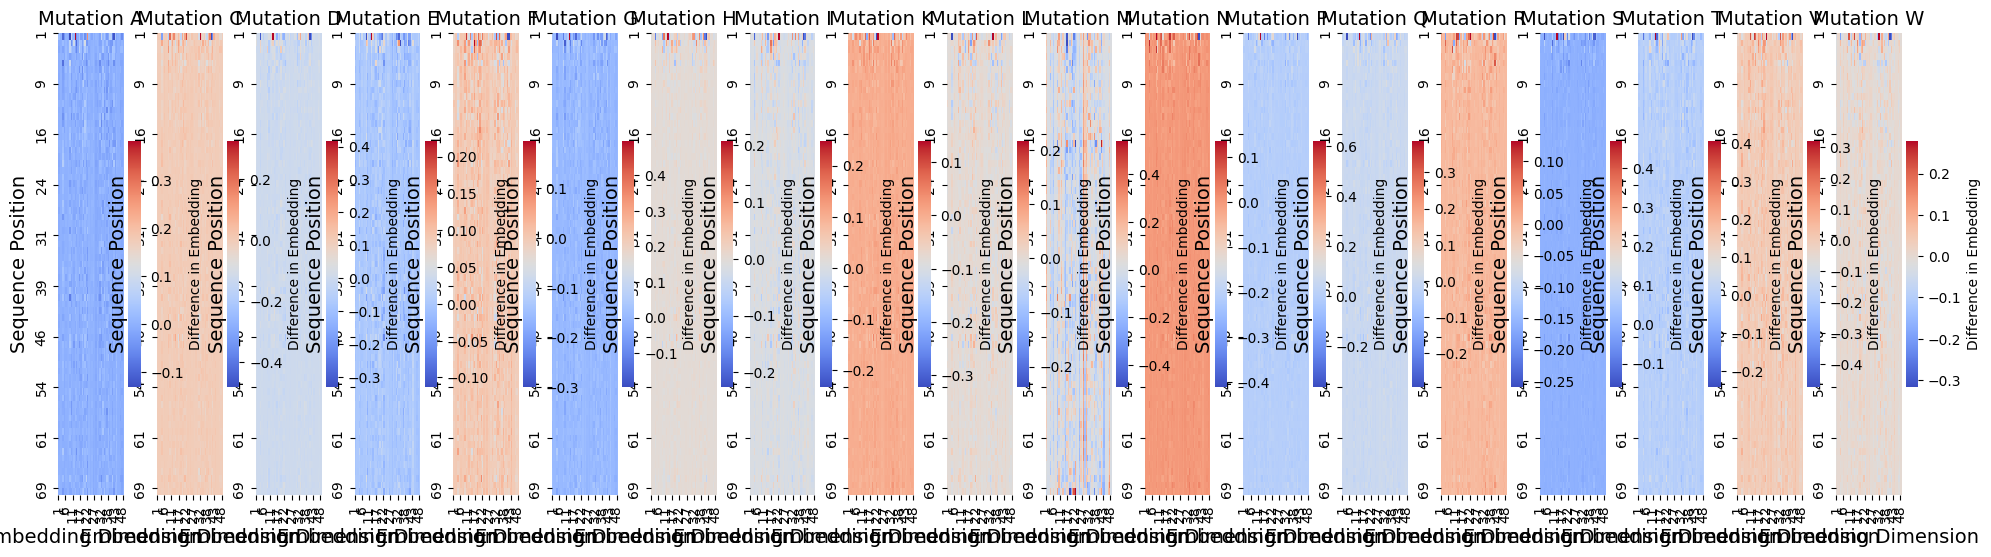

<ipython-input-49-a748032e0da5>:80: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


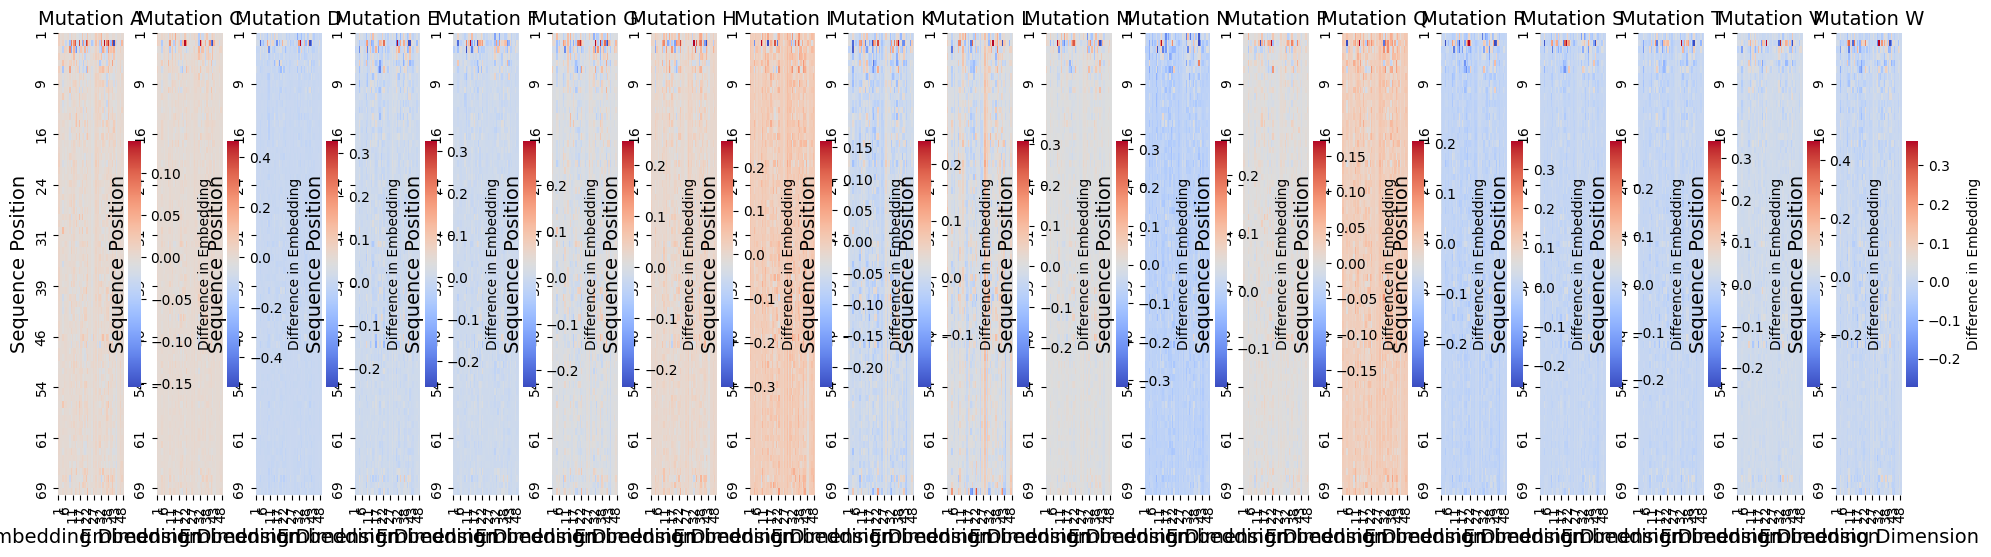

KeyboardInterrupt: 

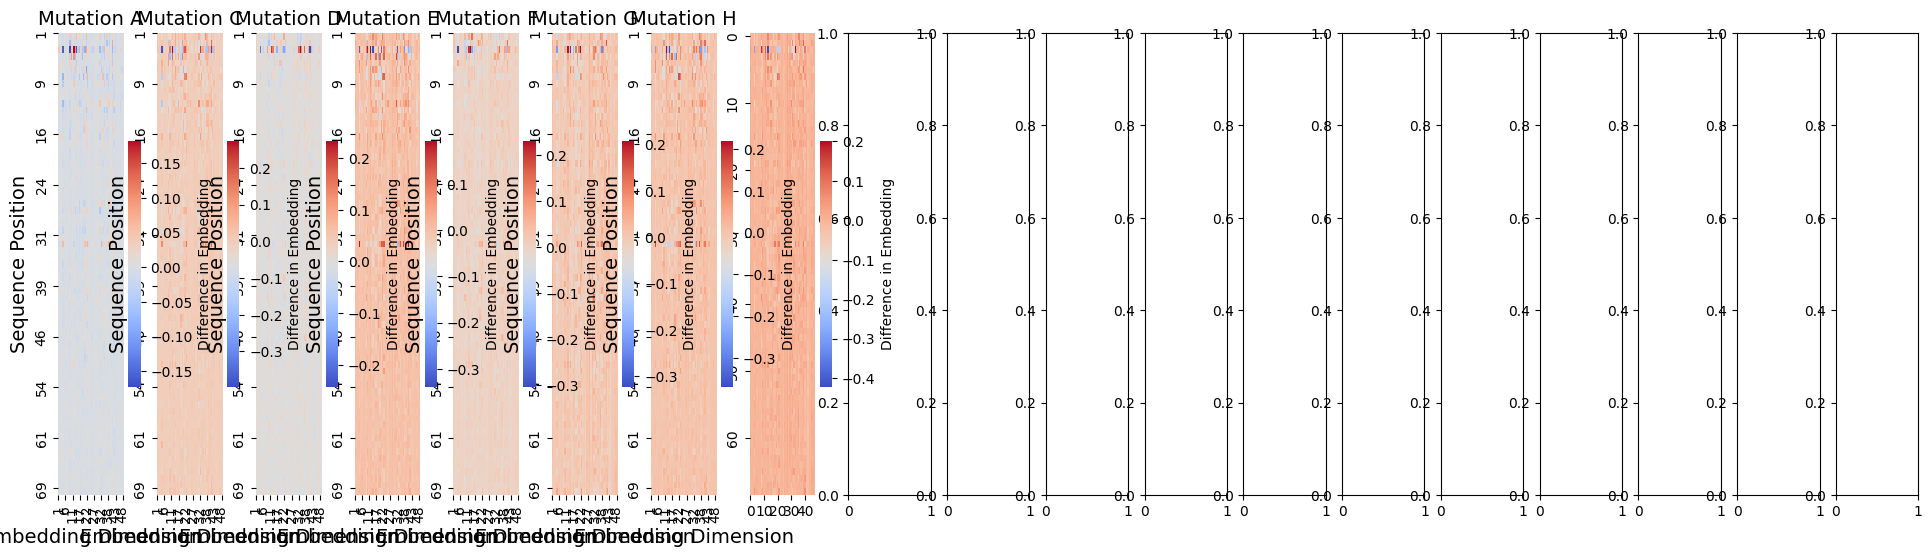

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load saved embeddings for mutations and wild-type
with open("/content/drive/MyDrive/embedding_data/least/mutations/1AOY_mutations_least_embeddings.pkl", "rb") as f:
    mutations_embeddings = pickle.load(f)

# Load the wild-type embedding
original_selected_embedding = np.load("/content/drive/MyDrive/embedding_data/least/original/1AOY_wildtype_least_embedding.npy")

# List of amino acids
amino_acids = "A C D E F G H I K L M N P Q R S T V W Y".split()

# Prepare a list to store the embedding differences
embedding_differences = []

# Iterate over each mutation position
for pos, position_mutations in mutations_embeddings.items():
    mutation_diffs = []

    # Get the wild-type embedding for the position
    wt_embedding = original_selected_embedding[0]

    # For each mutated version of the protein at this position
    for aa, mutated_embedding in position_mutations:
        mutated_emb = mutated_embedding[0]  # First sequence embedding for mutated protein
        diff = mutated_emb - wt_embedding  # Calculate the difference between mutated and wild-type
        mutation_diffs.append(diff)

    # Add the difference for this position
    embedding_differences.append(mutation_diffs)

# Convert embedding differences to a numpy array (for heatmap plotting)
embedding_differences = np.array(embedding_differences)  # Shape: (positions, mutations, dimensions)

# Get the number of sequence positions (length of the protein sequence)
num_sequence_positions = original_selected_embedding.shape[1]
num_embedding_dims = original_selected_embedding.shape[2]  # Number of embedding dimensions

# Plotting the heatmap for each mutated position
for pos in range(len(embedding_differences)):
    mutation_diffs = embedding_differences[pos]  # Get the mutation differences for this position

    # Create a new figure for each position
    fig, axes = plt.subplots(1, 19, figsize=(24, 6))  # 19 heatmaps (one per mutation)
    axes = axes.flatten()  # Flatten axes for easy iteration

    # Customize font sizes for the labels and ticks
    tick_fontsize = 10
    label_fontsize = 14

    # For each mutation (19 mutations per position)
    for i, (mutation_diff, ax) in enumerate(zip(mutation_diffs, axes)):
        # Plot the heatmap for this specific mutation
        sns.heatmap(mutation_diff, cmap="coolwarm", ax=ax, cbar=True,
                    xticklabels=10, yticklabels=10, cbar_kws={'label': 'Difference in Embedding'},
                    annot=False)

        # Set title, labels, and adjust the font size
        ax.set_title(f"Mutation {amino_acids[i]}", fontsize=label_fontsize)
        ax.set_xlabel("Embedding Dimension", fontsize=label_fontsize)
        ax.set_ylabel("Sequence Position", fontsize=label_fontsize)

        # Increase font size for tick labels
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

        # Set the sequence positions (y-axis) dynamically based on the sequence length
        y_ticks = np.linspace(0, num_sequence_positions - 1, num=10)  # 10 ticks for sequence positions
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(np.round(np.linspace(1, num_sequence_positions, num=10)).astype(int))  # Sequence positions

        # Set the embedding dimensions (x-axis) dynamically based on the number of features
        x_ticks = np.linspace(0, num_embedding_dims - 1, num=10)  # 10 ticks for embedding dimensions
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(np.round(np.linspace(1, num_embedding_dims, num=10)).astype(int))  # Embedding dimensions


    plt.tight_layout()
    plt.show()


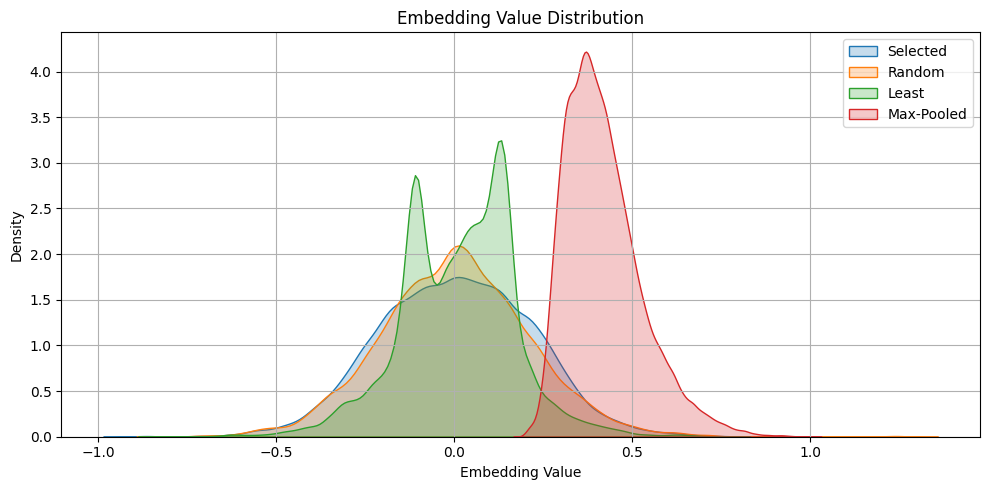

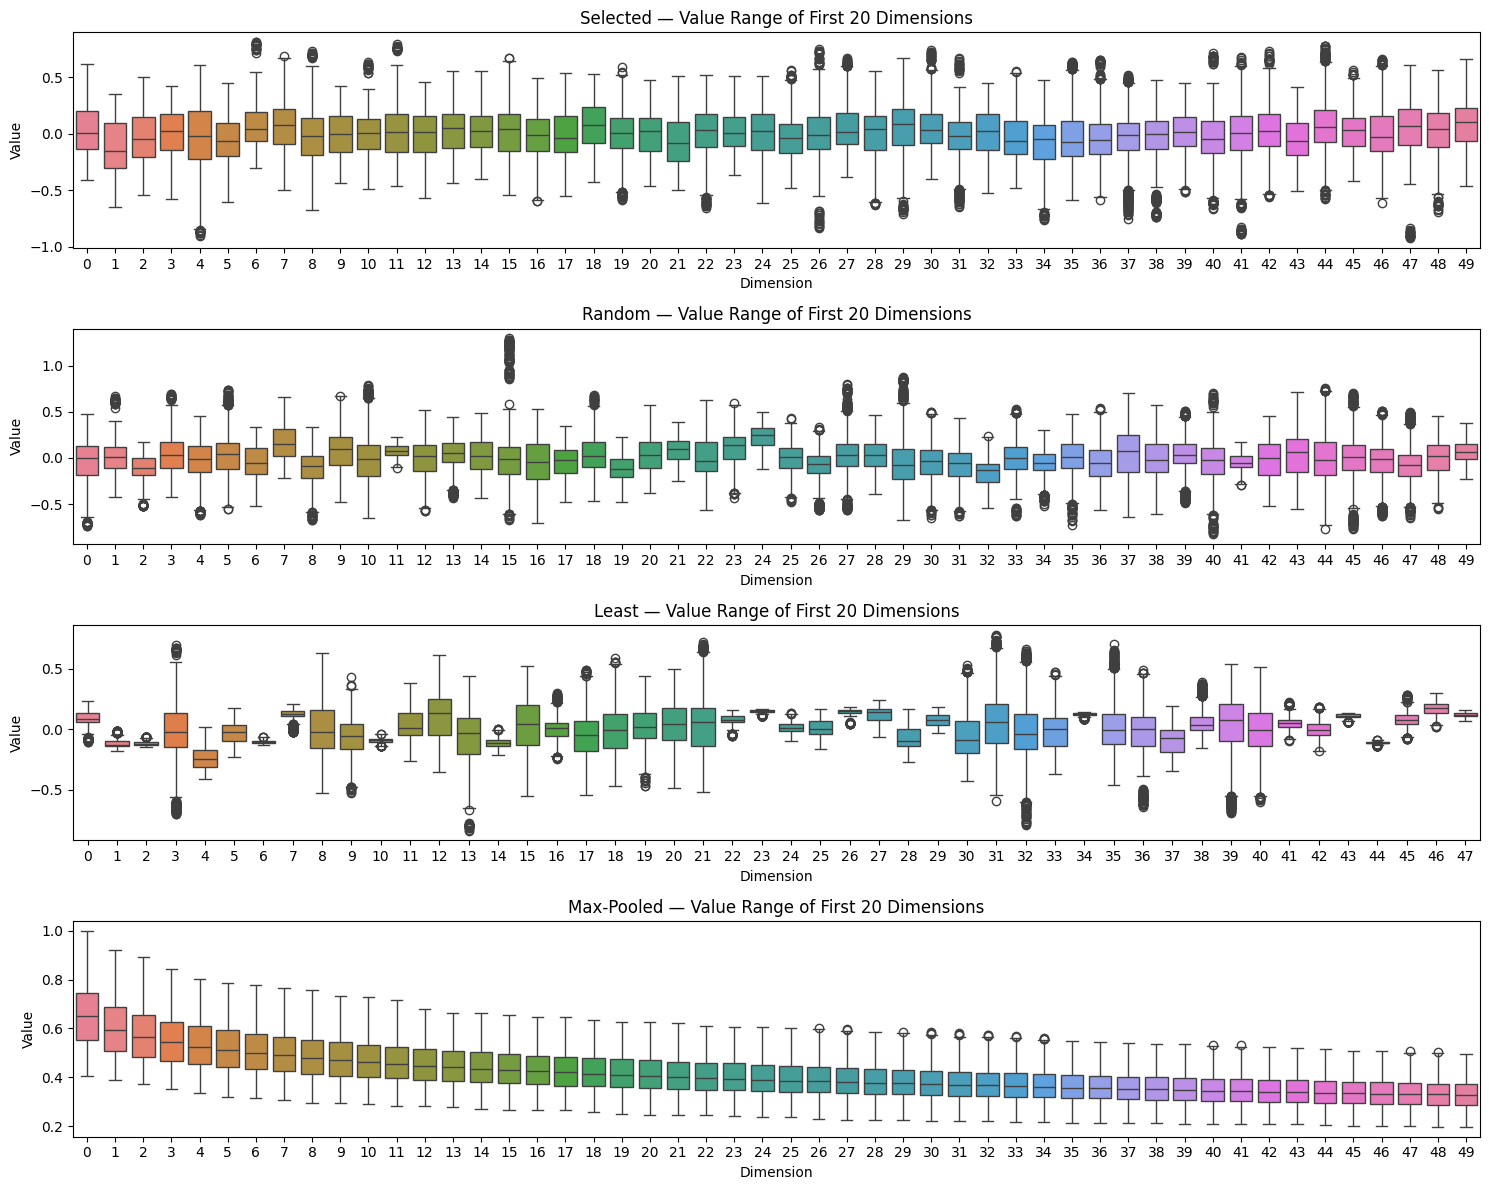

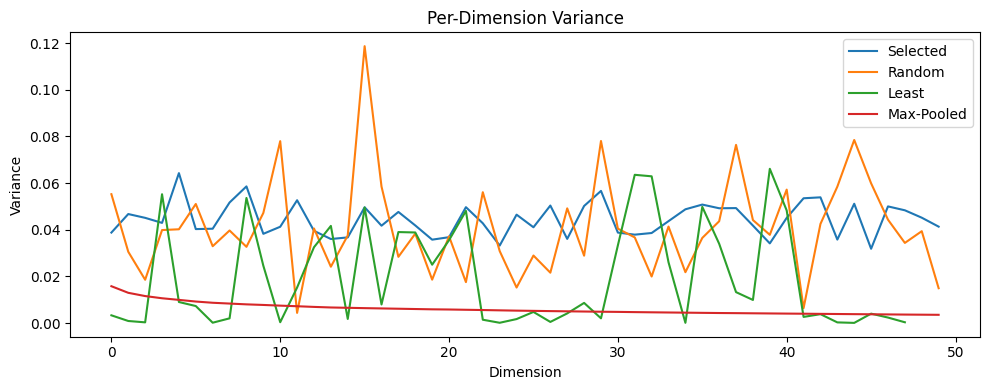

In [ ]:
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# === Paths ===
base_path = "/content/drive/MyDrive/embedding_data-2/embedding_data"
mut_dirs = {
    "Selected": os.path.join(base_path, "selected/mutations"),
    "Random": os.path.join(base_path, "random/mutations"),
    "Least": os.path.join(base_path, "least/mutations"),
    "Max-Pooled": os.path.join(base_path, "max/mutations")
}

def load_mutation_vecs(directory, max_entries=2000):
    vecs = []
    for fname in os.listdir(directory):
        if not fname.endswith(".pkl"):
            continue
        try:
            with open(os.path.join(directory, fname), "rb") as f:
                mut_dict = pickle.load(f)
            for pos, mutations in mut_dict.items():
                for aa, emb in mutations:
                    vecs.append(emb[0][pos])
                    if len(vecs) >= max_entries:
                        return np.array(vecs)
        except:
            continue
    return np.array(vecs)

# Load all vectors
embedding_data = {
    name: load_mutation_vecs(path)
    for name, path in mut_dirs.items()
}

#  1. KDE of all values
plt.figure(figsize=(10, 5))
for name, vecs in embedding_data.items():
    sns.kdeplot(vecs.flatten(), label=name, fill=True)
plt.title("Embedding Value Distribution")
plt.xlabel("Embedding Value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# 2. Boxplot per-dimension
plt.figure(figsize=(15, 12))
for i, (name, vecs) in enumerate(embedding_data.items(), 1):
    plt.subplot(4, 1, i)
    sns.boxplot(data=pd.DataFrame(vecs[:, :50]))
    plt.title(f"{name} — Value Range of all Dimensions")
    plt.xlabel("Dimension")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

#  3. Variance per dimension
plt.figure(figsize=(10, 4))
for name, vecs in embedding_data.items():
    plt.plot(np.var(vecs, axis=0), label=name)
plt.title("Per-Dimension Variance")
plt.xlabel("Dimension")
plt.ylabel("Variance")
plt.legend()
plt.tight_layout()
plt.show()



🔁 Fold 1
 - MSE: 0.5281
 - MAE: 0.5356
 - R² : 0.5512


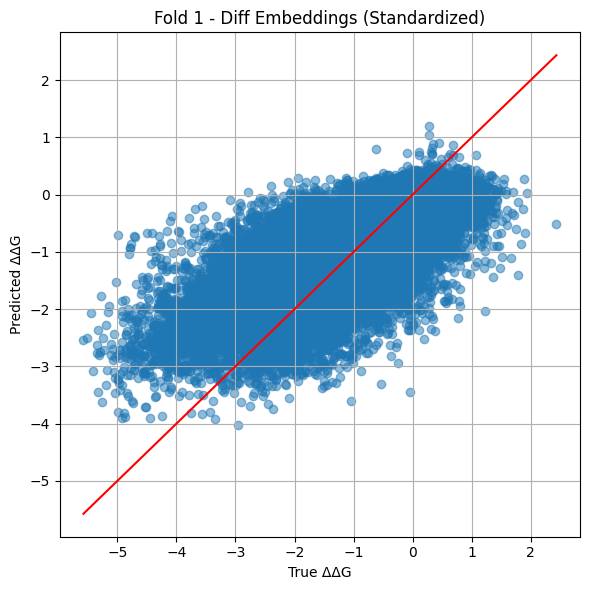


🔁 Fold 2
 - MSE: 0.5781
 - MAE: 0.5692
 - R² : 0.5050


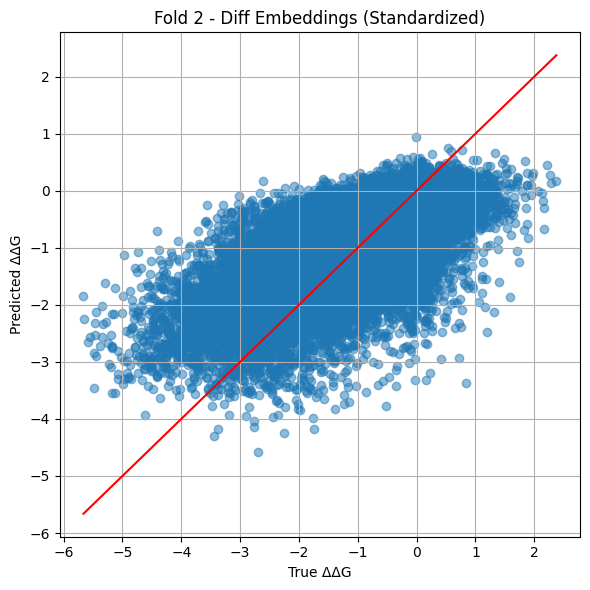


🔁 Fold 3
 - MSE: 0.5767
 - MAE: 0.5569
 - R² : 0.5275


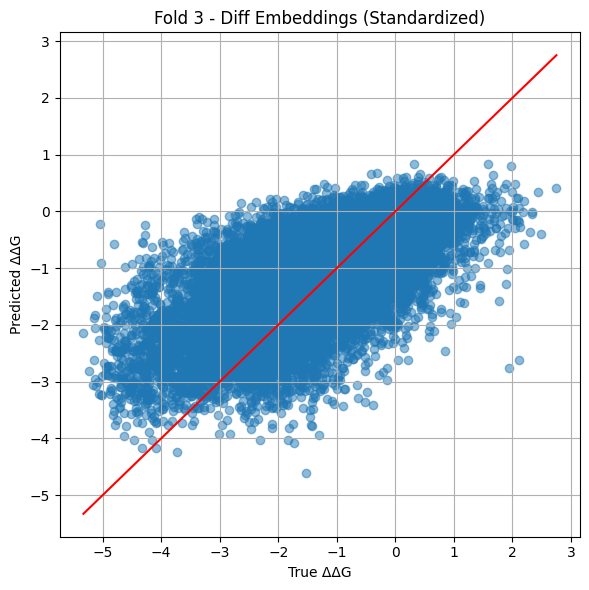


🔁 Fold 4
 - MSE: 0.5154
 - MAE: 0.5395
 - R² : 0.5444


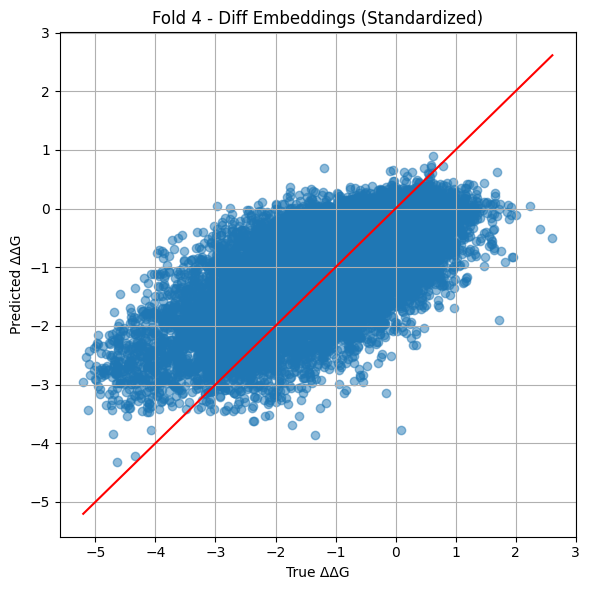


🔁 Fold 5
 - MSE: 0.5376
 - MAE: 0.5454
 - R² : 0.4202


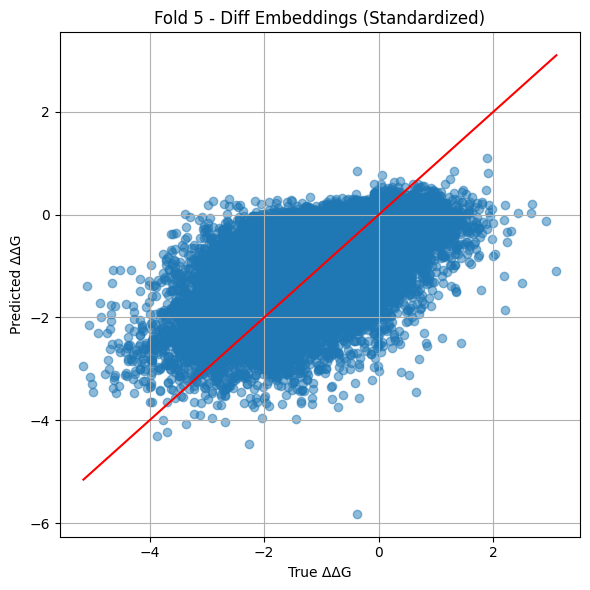


📊 Cross-Validation Summary
Avg MSE: 0.5472
Avg MAE: 0.5493
Avg R² : 0.5097


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Config
csv_dir = "/content/drive/MyDrive/TOP3DIMENSION/"
mut_dir = "/content/drive/MyDrive/embedding_data-2/embedding_data/selected/mutations"
wt_dir = "/content/drive/MyDrive/embedding_data-2/embedding_data/selected/original"

aa_order = "A C D E F G H I K L M N P Q R S T V W Y".split()
aa_to_index = {aa: i for i, aa in enumerate(aa_order)}

# Build dataset with WT - MUT difference embeddings
X_all, y_all, groups = [], [], []

for file in os.listdir(csv_dir):
    if not file.endswith(".csv"):
        continue

    pdb_id = file.replace("merged_with_dimension_features_", "").replace(".csv", "")
    mut_path = os.path.join(mut_dir, f"{pdb_id}_mutations_selected_embeddings.pkl")
    wt_path = os.path.join(wt_dir, f"{pdb_id}_wildtype_selected_embedding.npy")
    csv_path = os.path.join(csv_dir, file)

    if not (os.path.exists(mut_path) and os.path.exists(wt_path)):
        continue

    try:
        with open(mut_path, "rb") as f:
            mutations = pickle.load(f)
        wt_embedding = np.load(wt_path)[0]  # (L, 50)
        df = pd.read_csv(csv_path)

        for _, row in df.iterrows():
            try:
                pos = int(row["Position"]) - 1
                aa = row["Mutant"]
                ddg = float(row["ddG_ML"])

                if aa not in aa_to_index or (pos + 1) not in mutations:
                    continue

                for aa_mut, emb in mutations[pos + 1]:
                    if aa_mut == aa:
                        wt_vec = wt_embedding[pos]   # (50,)
                        mut_vec = emb[0][pos]        # (50,)
                        diff_vec = mut_vec - wt_vec  # (50,)
                        X_all.append(diff_vec)
                        y_all.append(ddg)
                        groups.append(pdb_id)
                        break
            except:
                continue
    except:
        continue

# Convert to NumPy arrays
X_all = np.array(X_all)
y_all = np.array(y_all)
groups = np.array(groups)

# Models
base_models = [
    ('xgb', XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05, random_state=42)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(128, 64), early_stopping=True, max_iter=1000, random_state=42)),
    ('ridge', RidgeCV())
]
stacked_model = StackingRegressor(estimators=base_models, final_estimator=RidgeCV())

# GroupKFold CV with standardization
gkf = GroupKFold(n_splits=5)
mse_list, mae_list, r2_list = [], [], []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups=groups)):
    print(f"\n Fold {fold + 1}")
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    stacked_model.fit(X_train_scaled, y_train)
    preds = stacked_model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f" - MSE: {mse:.4f}")
    print(f" - MAE: {mae:.4f}")
    print(f" - R² : {r2:.4f}")

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, preds, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.xlabel("True ΔΔG")
    plt.ylabel("Predicted ΔΔG")
    plt.title(f"Fold {fold + 1} - Diff Embeddings (Standardized)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Summary
print("\n Cross-Validation Summary")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg R² : {np.mean(r2_list):.4f}")



🔁 Fold 1
 - MSE: 0.5472
 - MAE: 0.5511
 - R² : 0.5393


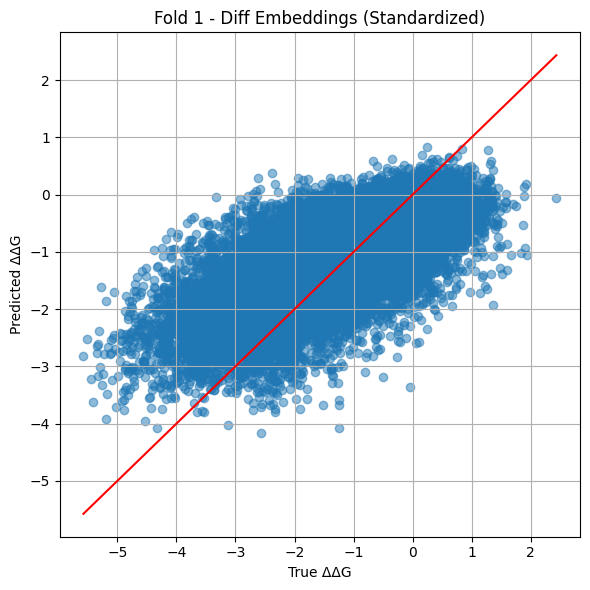


🔁 Fold 2
 - MSE: 0.5903
 - MAE: 0.5745
 - R² : 0.4657


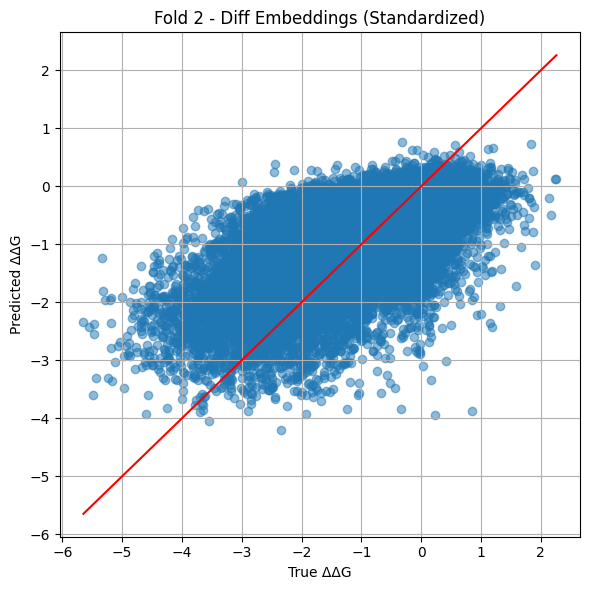


🔁 Fold 3
 - MSE: 0.5797
 - MAE: 0.5686
 - R² : 0.4939


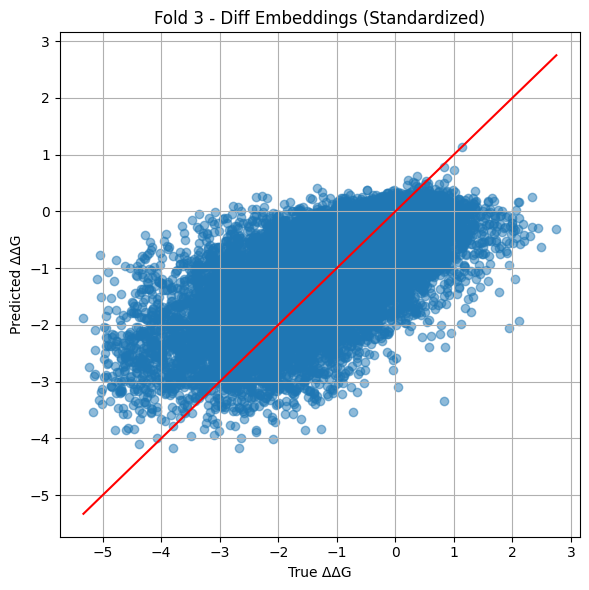


🔁 Fold 4
 - MSE: 0.5796
 - MAE: 0.5599
 - R² : 0.5011


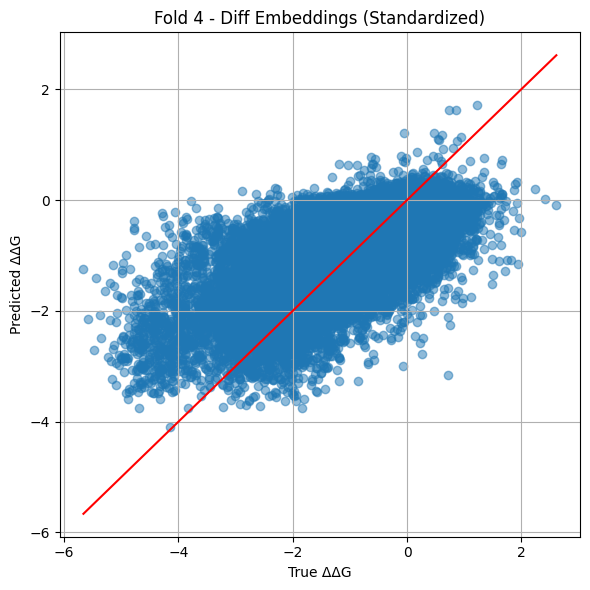


🔁 Fold 5
 - MSE: 0.5924
 - MAE: 0.5711
 - R² : 0.4069


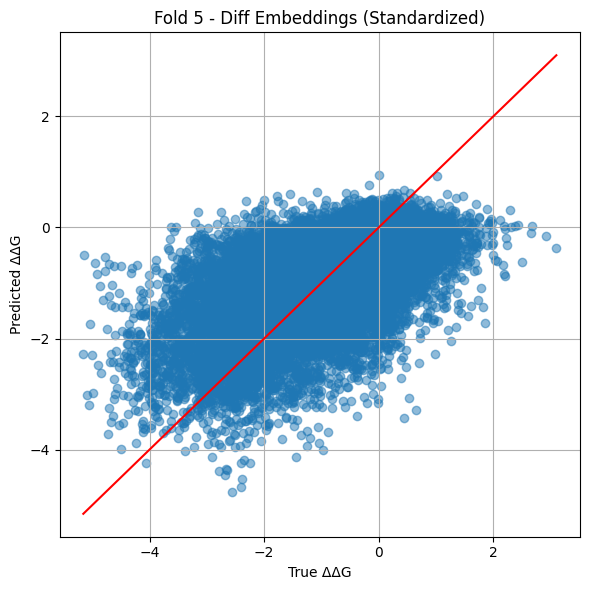


📊 Cross-Validation Summary
Avg MSE: 0.5779
Avg MAE: 0.5650
Avg R² : 0.4814


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Config
csv_dir = "/content/drive/MyDrive/TOP3DIMENSION/"
mut_dir = "/content/drive/MyDrive/embedding_data-2/embedding_data/random/mutations"
wt_dir = "/content/drive/MyDrive/embedding_data-2/embedding_data/random/original"

aa_order = "A C D E F G H I K L M N P Q R S T V W Y".split()
aa_to_index = {aa: i for i, aa in enumerate(aa_order)}

# Build dataset with WT - MUT difference embeddings
X_all, y_all, groups = [], [], []

for file in os.listdir(csv_dir):
    if not file.endswith(".csv"):
        continue

    pdb_id = file.replace("merged_with_dimension_features_", "").replace(".csv", "")
    mut_path = os.path.join(mut_dir, f"{pdb_id}_mutations_random_embeddings.pkl")
    wt_path = os.path.join(wt_dir, f"{pdb_id}_wildtype_random_embedding.npy")
    csv_path = os.path.join(csv_dir, file)

    if not (os.path.exists(mut_path) and os.path.exists(wt_path)):
        continue

    try:
        with open(mut_path, "rb") as f:
            mutations = pickle.load(f)
        wt_embedding = np.load(wt_path)[0]  # (L, 50)
        df = pd.read_csv(csv_path)

        for _, row in df.iterrows():
            try:
                pos = int(row["Position"]) - 1
                aa = row["Mutant"]
                ddg = float(row["ddG_ML"])

                if aa not in aa_to_index or (pos + 1) not in mutations:
                    continue

                for aa_mut, emb in mutations[pos + 1]:
                    if aa_mut == aa:
                        wt_vec = wt_embedding[pos]   # (50,)
                        mut_vec = emb[0][pos]        # (50,)
                        diff_vec = mut_vec - wt_vec  # (50,)
                        X_all.append(diff_vec)
                        y_all.append(ddg)
                        groups.append(pdb_id)
                        break
            except:
                continue
    except:
        continue

# Convert to NumPy arrays
X_all = np.array(X_all)
y_all = np.array(y_all)
groups = np.array(groups)

# Models
base_models = [
    ('xgb', XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05, random_state=42)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(128, 64), early_stopping=True, max_iter=1000, random_state=42)),
    ('ridge', RidgeCV())
]
stacked_model = StackingRegressor(estimators=base_models, final_estimator=RidgeCV())

# GroupKFold CV with standardization
gkf = GroupKFold(n_splits=5)
mse_list, mae_list, r2_list = [], [], []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups=groups)):
    print(f"\n Fold {fold + 1}")
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    stacked_model.fit(X_train_scaled, y_train)
    preds = stacked_model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f" - MSE: {mse:.4f}")
    print(f" - MAE: {mae:.4f}")
    print(f" - R² : {r2:.4f}")

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, preds, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.xlabel("True ΔΔG")
    plt.ylabel("Predicted ΔΔG")
    plt.title(f"Fold {fold + 1} - Diff Embeddings (Standardized)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Summary
print("\n Cross-Validation Summary")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg R² : {np.mean(r2_list):.4f}")



🔁 Fold 1
 - MSE: 0.6171
 - MAE: 0.5800
 - R² : 0.4794


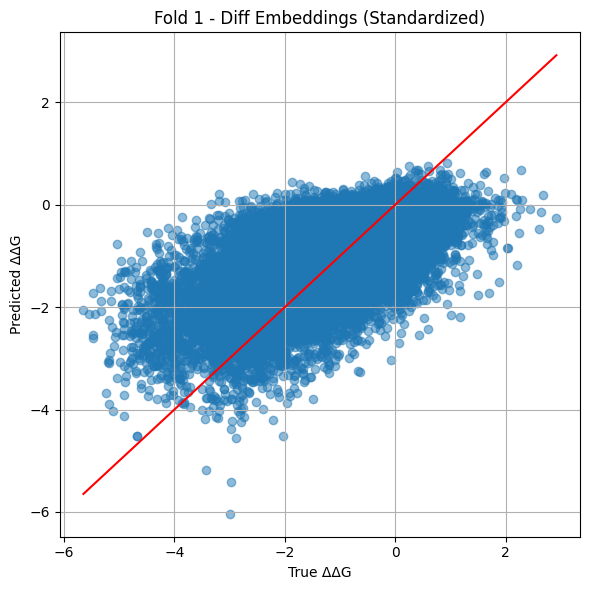


🔁 Fold 2
 - MSE: 0.6030
 - MAE: 0.5777
 - R² : 0.5116


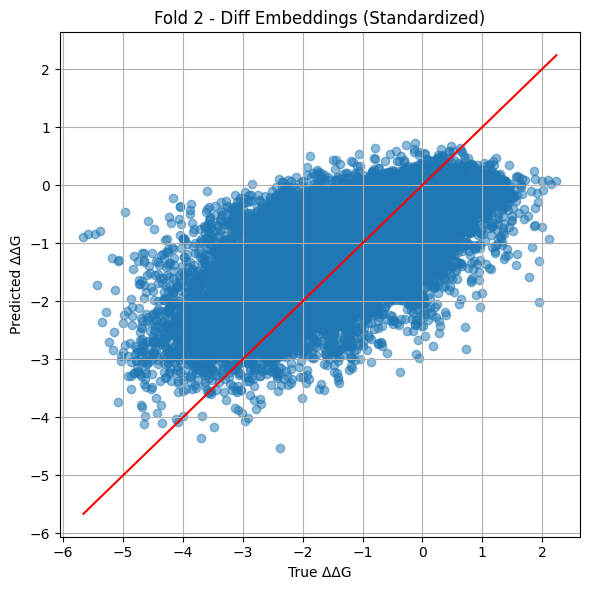


🔁 Fold 3
 - MSE: 0.5710
 - MAE: 0.5668
 - R² : 0.4709


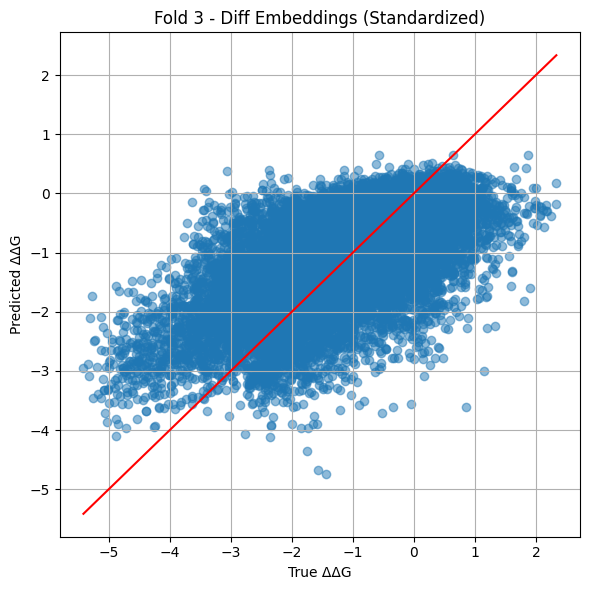


🔁 Fold 4
 - MSE: 0.6120
 - MAE: 0.5864
 - R² : 0.4533


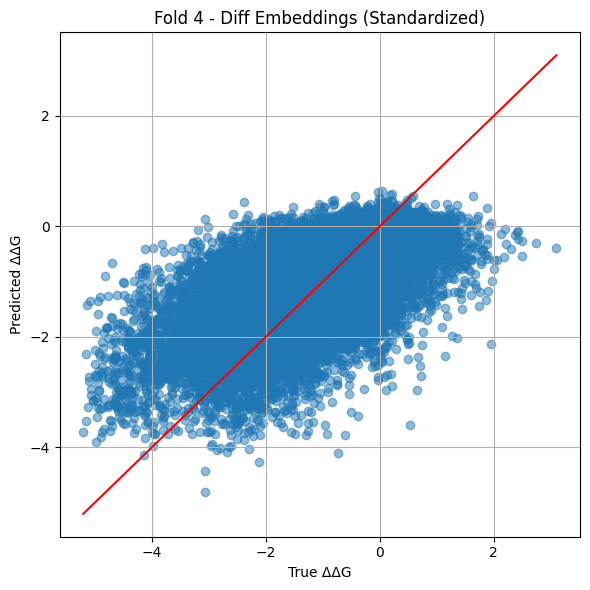


🔁 Fold 5
 - MSE: 0.5694
 - MAE: 0.5721
 - R² : 0.4629


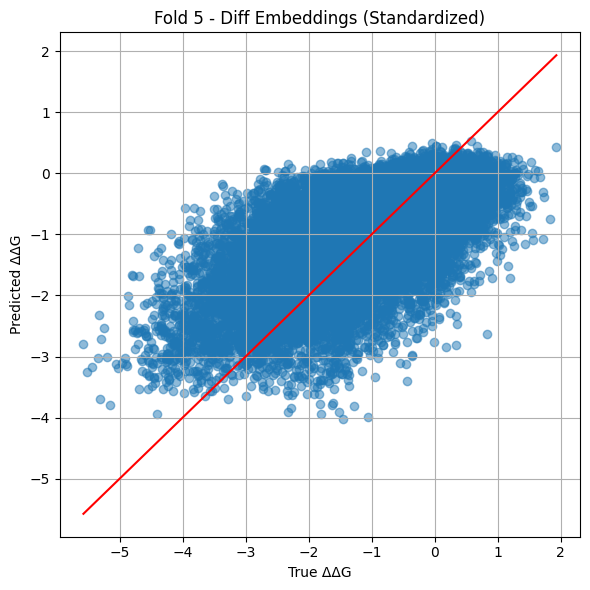


📊 Cross-Validation Summary
Avg MSE: 0.5945
Avg MAE: 0.5766
Avg R² : 0.4756


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Config
csv_dir = "/content/drive/MyDrive/TOP3DIMENSION/"
mut_dir = "/content/drive/MyDrive/embedding_data-2/embedding_data/least/mutations"
wt_dir = "/content/drive/MyDrive/embedding_data-2/embedding_data/least/original"

aa_order = "A C D E F G H I K L M N P Q R S T V W Y".split()
aa_to_index = {aa: i for i, aa in enumerate(aa_order)}

# Build dataset with WT - MUT difference embeddings
X_all, y_all, groups = [], [], []

for file in os.listdir(csv_dir):
    if not file.endswith(".csv"):
        continue

    pdb_id = file.replace("merged_with_dimension_features_", "").replace(".csv", "")
    mut_path = os.path.join(mut_dir, f"{pdb_id}_mutations_least_embeddings.pkl")
    wt_path = os.path.join(wt_dir, f"{pdb_id}_wildtype_least_embedding.npy")
    csv_path = os.path.join(csv_dir, file)

    if not (os.path.exists(mut_path) and os.path.exists(wt_path)):
        continue

    try:
        with open(mut_path, "rb") as f:
            mutations = pickle.load(f)
        wt_embedding = np.load(wt_path)[0]  # (L, 50)
        df = pd.read_csv(csv_path)

        for _, row in df.iterrows():
            try:
                pos = int(row["Position"]) - 1
                aa = row["Mutant"]
                ddg = float(row["ddG_ML"])

                if aa not in aa_to_index or (pos + 1) not in mutations:
                    continue

                for aa_mut, emb in mutations[pos + 1]:
                    if aa_mut == aa:
                        wt_vec = wt_embedding[pos]   # (50,)
                        mut_vec = emb[0][pos]        # (50,)
                        diff_vec = mut_vec - wt_vec  # (50,)
                        X_all.append(diff_vec)
                        y_all.append(ddg)
                        groups.append(pdb_id)
                        break
            except:
                continue
    except:
        continue

# Convert to NumPy arrays
X_all = np.array(X_all)
y_all = np.array(y_all)
groups = np.array(groups)

# Models
base_models = [
    ('xgb', XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05, random_state=42)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(128, 64), early_stopping=True, max_iter=1000, random_state=42)),
    ('ridge', RidgeCV())
]
stacked_model = StackingRegressor(estimators=base_models, final_estimator=RidgeCV())

# GroupKFold CV with standardization
gkf = GroupKFold(n_splits=5)
mse_list, mae_list, r2_list = [], [], []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups=groups)):
    print(f"\n Fold {fold + 1}")
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    stacked_model.fit(X_train_scaled, y_train)
    preds = stacked_model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f" - MSE: {mse:.4f}")
    print(f" - MAE: {mae:.4f}")
    print(f" - R² : {r2:.4f}")

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, preds, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.xlabel("True ΔΔG")
    plt.ylabel("Predicted ΔΔG")
    plt.title(f"Fold {fold + 1} - Diff Embeddings (Standardized)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#  Summary
print("\n Cross-Validation Summary")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg R² : {np.mean(r2_list):.4f}")



🔁 Fold 1
 - MSE: 1.0389
 - MAE: 0.7949
 - R² : 0.1009


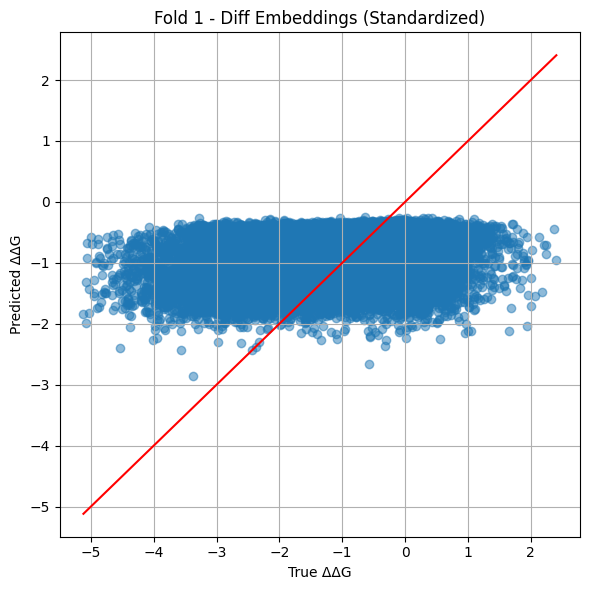


🔁 Fold 2
 - MSE: 1.0914
 - MAE: 0.8112
 - R² : 0.1060


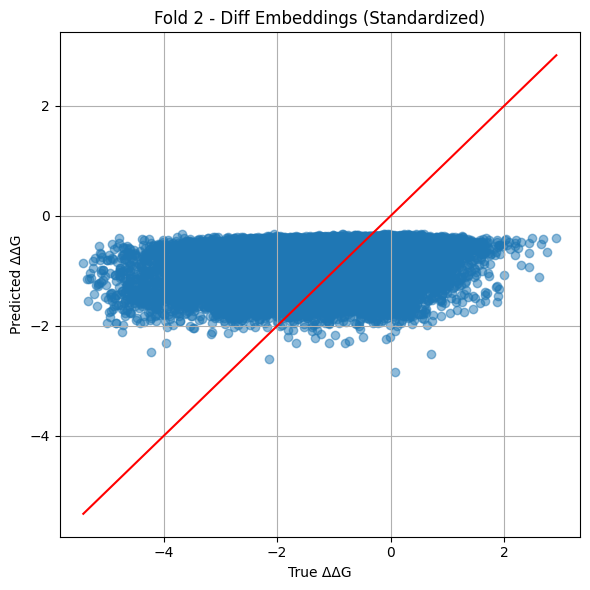


🔁 Fold 3
 - MSE: 1.0137
 - MAE: 0.7709
 - R² : 0.1072


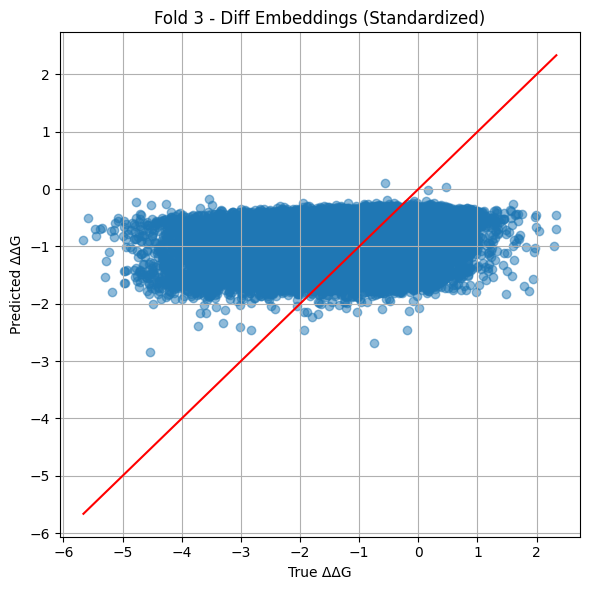


🔁 Fold 4
 - MSE: 0.9631
 - MAE: 0.7663
 - R² : 0.0832


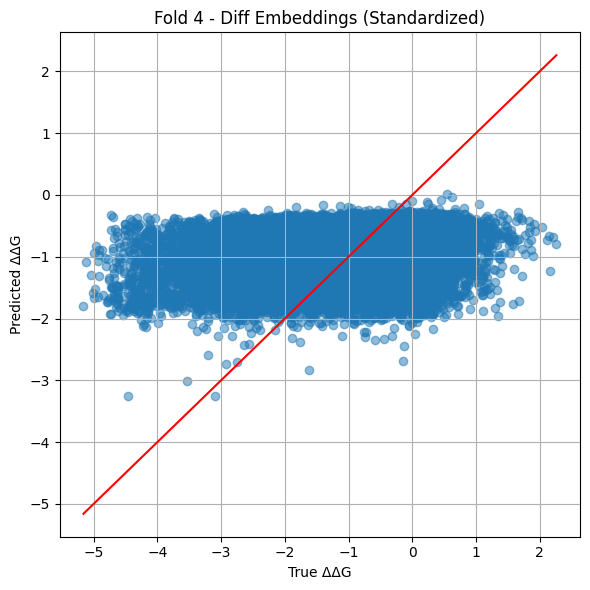


🔁 Fold 5
 - MSE: 1.0013
 - MAE: 0.7692
 - R² : 0.1314


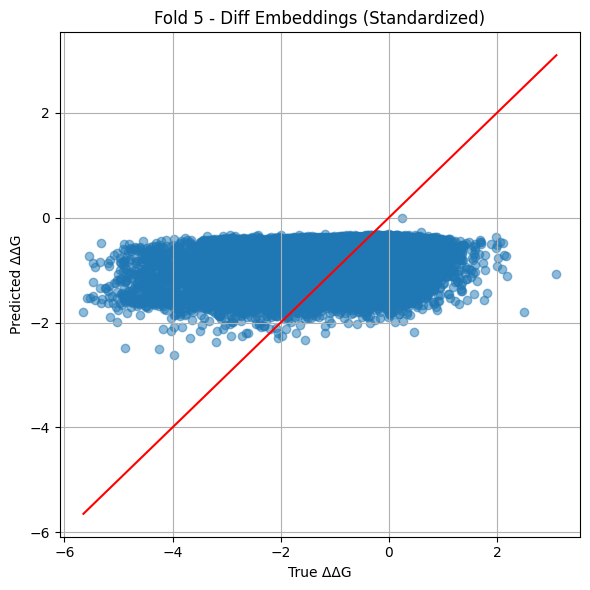


📊 Cross-Validation Summary
Avg MSE: 1.0217
Avg MAE: 0.7825
Avg R² : 0.1057


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Config
csv_dir = "/content/drive/MyDrive/TOP3DIMENSION/"
mut_dir = "/content/drive/MyDrive/embedding_data-2/embedding_data/max/mutations"
wt_dir = "/content/drive/MyDrive/embedding_data-2/embedding_data/max/original"

aa_order = "A C D E F G H I K L M N P Q R S T V W Y".split()
aa_to_index = {aa: i for i, aa in enumerate(aa_order)}

# Build dataset with WT - MUT difference embeddings
X_all, y_all, groups = [], [], []

for file in os.listdir(csv_dir):
    if not file.endswith(".csv"):
        continue

    pdb_id = file.replace("merged_with_dimension_features_", "").replace(".csv", "")
    mut_path = os.path.join(mut_dir, f"{pdb_id}_mutations_maxpool_embeddings.pkl")
    wt_path = os.path.join(wt_dir, f"{pdb_id}_wildtype_maxpool_embedding.npy")
    csv_path = os.path.join(csv_dir, file)

    if not (os.path.exists(mut_path) and os.path.exists(wt_path)):
        continue

    try:
        with open(mut_path, "rb") as f:
            mutations = pickle.load(f)
        wt_embedding = np.load(wt_path)[0]  # (L, 50)
        df = pd.read_csv(csv_path)

        for _, row in df.iterrows():
            try:
                pos = int(row["Position"]) - 1
                aa = row["Mutant"]
                ddg = float(row["ddG_ML"])

                if aa not in aa_to_index or (pos + 1) not in mutations:
                    continue

                for aa_mut, emb in mutations[pos + 1]:
                    if aa_mut == aa:
                        wt_vec = wt_embedding[pos]   # (50,)
                        mut_vec = emb[0][pos]        # (50,)
                        diff_vec = mut_vec - wt_vec  # (50,)
                        X_all.append(diff_vec)
                        y_all.append(ddg)
                        groups.append(pdb_id)
                        break
            except:
                continue
    except:
        continue

# Convert to NumPy arrays
X_all = np.array(X_all)
y_all = np.array(y_all)
groups = np.array(groups)

# Models
base_models = [
    ('xgb', XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05, random_state=42)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(128, 64), early_stopping=True, max_iter=1000, random_state=42)),
    ('ridge', RidgeCV())
]
stacked_model = StackingRegressor(estimators=base_models, final_estimator=RidgeCV())

# GroupKFold CV with standardization
gkf = GroupKFold(n_splits=5)
mse_list, mae_list, r2_list = [], [], []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_all, y_all, groups=groups)):
    print(f"\n Fold {fold + 1}")
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    stacked_model.fit(X_train_scaled, y_train)
    preds = stacked_model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f" - MSE: {mse:.4f}")
    print(f" - MAE: {mae:.4f}")
    print(f" - R² : {r2:.4f}")

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, preds, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.xlabel("True ΔΔG")
    plt.ylabel("Predicted ΔΔG")
    plt.title(f"Fold {fold + 1} - Diff Embeddings (Standardized)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#  Summary
print("\n Cross-Validation Summary")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg R² : {np.mean(r2_list):.4f}")


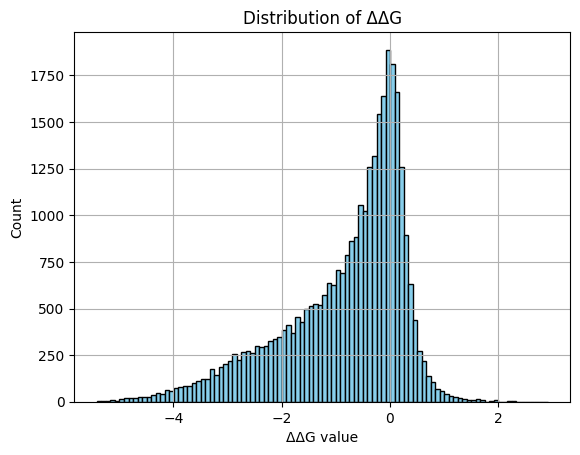

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_top_all, bins=100, color='skyblue', edgecolor='black')
plt.title("Distribution of ΔΔG")
plt.xlabel("ΔΔG value")
plt.ylabel("Count")
plt.grid(True)
plt.show()


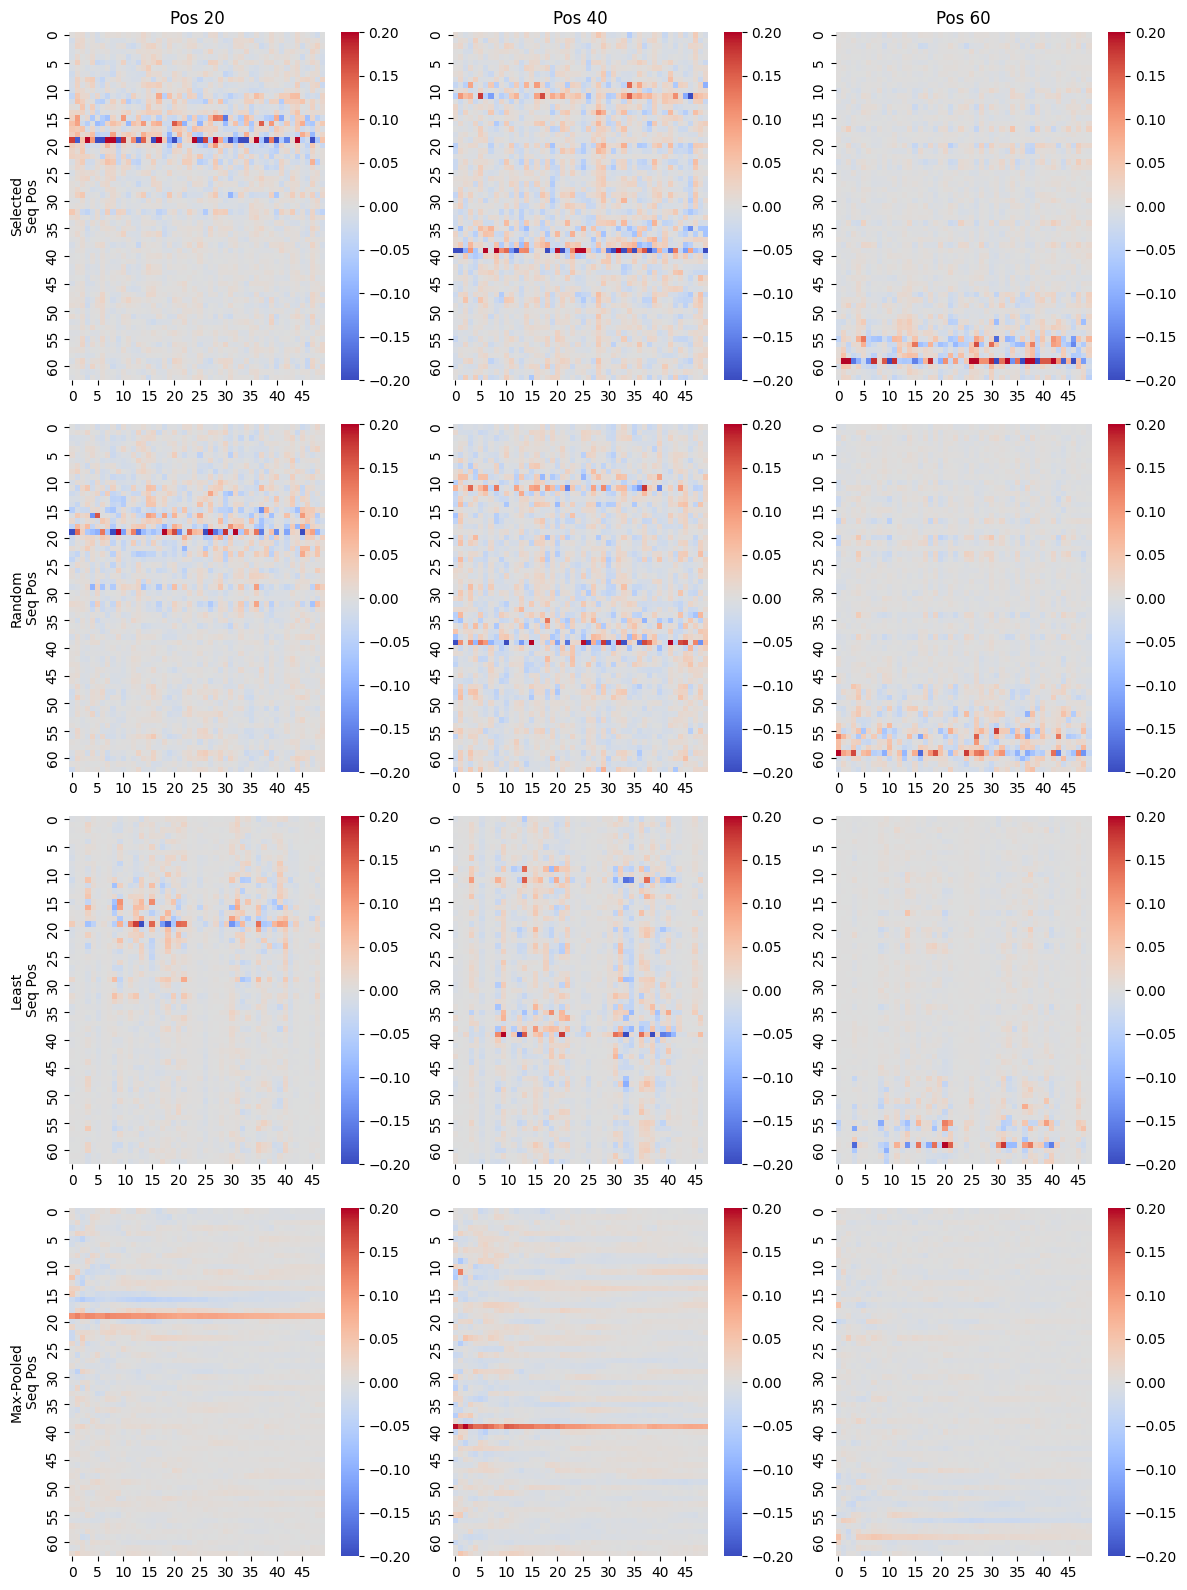

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
positions_to_plot = [20, 40, 60]
embedding_types = {
    "Selected": {
        "mut_path": "/content/drive/MyDrive/embedding_data-2/embedding_data/selected/mutations/1A32_mutations_selected_embeddings.pkl",
        "wt_path": "/content/drive/MyDrive/embedding_data-2/embedding_data/selected/original/1A32_wildtype_selected_embedding.npy"
    },
    "Random": {
        "mut_path": "/content/drive/MyDrive/embedding_data-2/embedding_data/random/mutations/1A32_mutations_random_embeddings.pkl",
        "wt_path": "/content/drive/MyDrive/embedding_data-2/embedding_data/random/original/1A32_wildtype_random_embedding.npy"
    },
    "Least": {
        "mut_path": "/content/drive/MyDrive/embedding_data-2/embedding_data/least/mutations/1A32_mutations_least_embeddings.pkl",
        "wt_path": "/content/drive/MyDrive/embedding_data-2/embedding_data/least/original/1A32_wildtype_least_embedding.npy"
    },
    "Max-Pooled": {
        "mut_path": "/content/drive/MyDrive/embedding_data-2/embedding_data/max/mutations/1A32_mutations_maxpool_embeddings.pkl",
        "wt_path": "/content/drive/MyDrive/embedding_data-2/embedding_data/max/original/1A32_wildtype_maxpool_embedding.npy"
    }
}

# Load and compute average diffs for each type
heatmaps = {}

for label, paths in embedding_types.items():
    try:
        with open(paths["mut_path"], "rb") as f:
            mutations = pickle.load(f)
        wt_embedding = np.load(paths["wt_path"])[0]  # (L, 50)
        L = wt_embedding.shape[0]

        avg_diffs = []

        for pos in positions_to_plot:
            if pos not in mutations:
                avg_diffs.append(np.zeros_like(wt_embedding))
                continue

            diffs = []
            for aa, emb in mutations[pos]:
                mut_embedding = emb[0]  # (L, 50)
                diff = mut_embedding - wt_embedding  # (L, 50)
                diffs.append(diff)
            avg_diff = np.mean(diffs, axis=0)
            avg_diffs.append(avg_diff)

        heatmaps[label] = np.array(avg_diffs)  # (len(positions), L, 50)

    except Exception as e:
        heatmaps[label] = None
        print(f"Failed to load {label}: {e}")

import matplotlib.pyplot as plt

# Plot heatmaps (normalized scale across all)
# vmin = min(np.min(h) for h in heatmaps.values() if h is not None)
# vmax = max(np.max(h) for h in heatmaps.values() if h is not None)
vmin = -0.2
vmax = 0.2

fig, axes = plt.subplots(len(embedding_types), len(positions_to_plot), figsize=(4 * len(positions_to_plot), 16))

for row_idx, (label, avg_diffs) in enumerate(heatmaps.items()):
    if avg_diffs is None:
        continue
    for col_idx, pos in enumerate(positions_to_plot):
        sns.heatmap(avg_diffs[col_idx], ax=axes[row_idx, col_idx],
                    cmap="coolwarm", center=0, vmin=vmin, vmax=vmax,
                    xticklabels=5, yticklabels=5)
        if row_idx == 0:
            axes[row_idx, col_idx].set_title(f"Pos {pos}")
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(f"{label}\nSeq Pos")

plt.tight_layout()
plt.show()


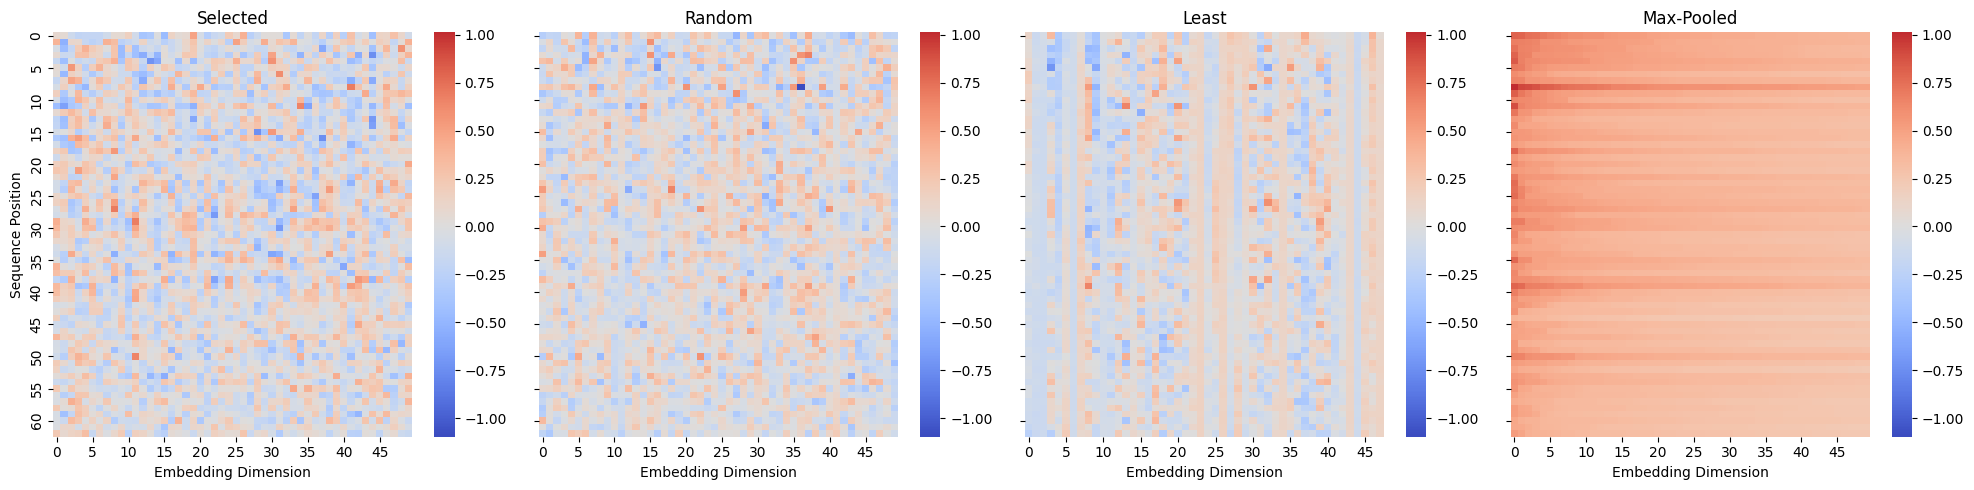

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

embedding_files = {
    "Selected": "/content/drive/MyDrive/embedding_data-2/embedding_data/selected/original/1A32_wildtype_selected_embedding.npy",
    "Random": "/content/drive/MyDrive/embedding_data-2/embedding_data/random/original/1A32_wildtype_random_embedding.npy",
    "Least": "/content/drive/MyDrive/embedding_data-2/embedding_data/least/original/1A32_wildtype_least_embedding.npy",
    "Max-Pooled": "/content/drive/MyDrive/embedding_data-2/embedding_data/max/original/1A32_wildtype_maxpool_embedding.npy"
}



# Load embeddings
wildtype_embeddings = {}
for label, path in embedding_files.items():
    if os.path.exists(path):
        try:
            wildtype_embeddings[label] = np.load(path)[0]  # shape: (L, 50)
        except Exception as e:
            wildtype_embeddings[label] = None
            print(f"Failed to load {label}: {e}")
    else:
        wildtype_embeddings[label] = None
        print(f"File not found for {label}: {path}")

# Determine global min/max for color scaling
vmin = min(np.min(emb) for emb in wildtype_embeddings.values() if emb is not None)
vmax = max(np.max(emb) for emb in wildtype_embeddings.values() if emb is not None)

# Plot heatmaps horizontally
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for idx, (label, emb) in enumerate(wildtype_embeddings.items()):
    if emb is not None:
        sns.heatmap(emb, ax=axes[idx], cmap="coolwarm", center=0, vmin=vmin, vmax=vmax,
                    xticklabels=5, yticklabels=5)
        axes[idx].set_title(label)
        axes[idx].set_xlabel("Embedding Dimension")
        if idx == 0:
            axes[idx].set_ylabel("Sequence Position")
    else:
        axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

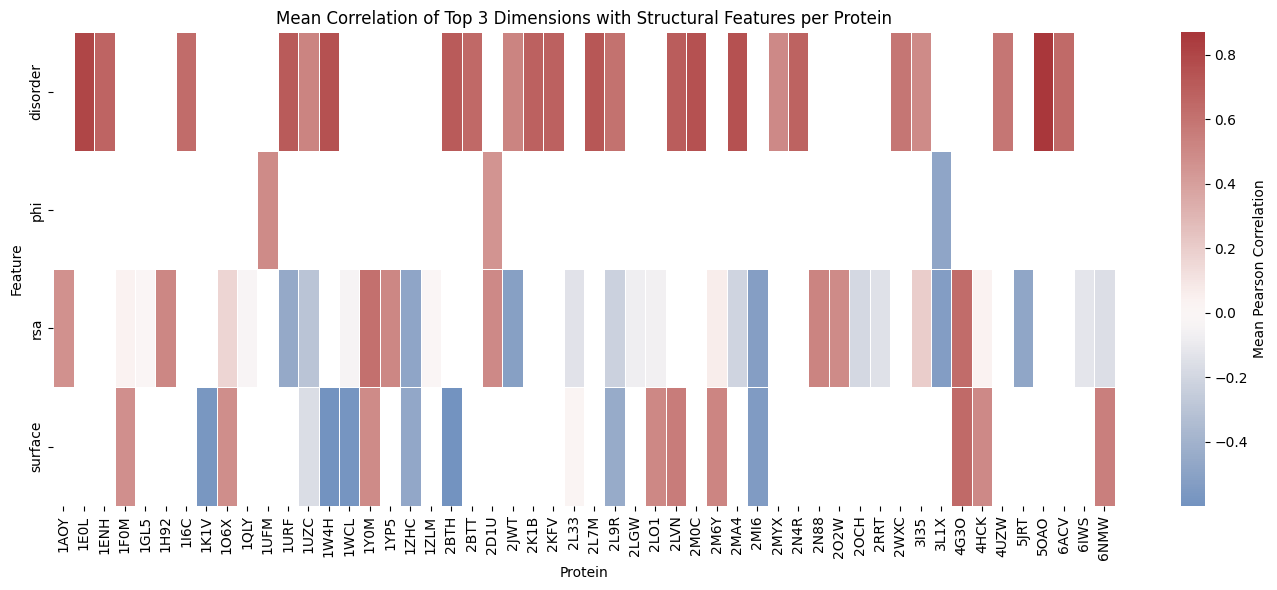

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path to the folder with extracted CSV files
extract_path = "/content/drive/MyDrive/top3_correlation_files/Top3_correlations"

# Step 1: Read and process all CSV files
summary_data = []

for file_name in os.listdir(extract_path):
    if file_name.endswith(".csv"):
        protein_id = os.path.splitext(file_name)[0].replace("correlations_alphasync_", "")
        file_path = os.path.join(extract_path, file_name)
        try:
            df = pd.read_csv(file_path)
            if 'Feature' in df.columns and 'Correlation' in df.columns and 'Corrected_pval' in df.columns:
                df['Protein'] = protein_id
                summary_data.append(df)
        except Exception as e:
            print(f"Failed to read {file_name}: {e}")

# Combine and process
if summary_data:
    all_correlations = pd.concat(summary_data, ignore_index=True)

    # Step 2: Filter and summarize
    significant = all_correlations[all_correlations['Corrected_pval'] < 0.05]
    mean_corr_by_feature = significant.groupby('Feature')['Correlation'].agg(['mean', 'median', 'count']).reset_index()

    # Step 3: Heatmap
    pivot_table = significant.pivot_table(index='Feature', columns='Protein', values='Correlation', aggfunc='mean')

    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot_table, cmap="vlag", center=0, annot=False, linewidths=0.5, cbar_kws={"label": "Mean Pearson Correlation"})
    plt.title("Mean Correlation of Top 3 Dimensions with Structural Features per Protein")
    plt.tight_layout()
    plt.show()
else:
    print("No valid CSV files with required columns found.")


In [ ]:
# Get unique labels (if 'Label' column exists)
if 'Label' in all_correlations.columns:
    unique_labels = all_correlations['Label'].unique()
    print("Unique Label values:")
    print(unique_labels)
else:
    print("No 'Label' column found in the data.")


Unique Label values:
[ 722   15  801  570  264  330  555  847  707  717 1002   90  648  791
  983  773  965  701  265   88  278  230  161  376  518  675  580  415
  691  574  997  768  213   43  141  297  977  351  840  948  154  310
   89  984  159  664   17  943  654  655   19  487  598  275  423  688
  111   48  407  453  514   99  738  476  567  956  865  804  996  705
  279  993  416  464  718    6  219 1017  628  641  921  195  588  931
  332  125  782  728  412  122  341  381   40  253   12  652  505  546
  743  916  252  300  645  475  669  706  451  538  702  573   21  527
  124  621  208  137  350  104  274  385   74   37  760  772  798  848
  349  842  394  459  539  138  268   82  280  930  874  336  740  182
  387  833  979  473  340  369  644  727  128  489  936  337  126  531
  325  334  435  512  681  922  749  540  809  410  484  420  631  676
  684  198  452  314  424  710]


In [ ]:
selected_dims = {
    407, 648, 15, 710, 823, 45, 104, 1018, 453, 791, 394, 988, 997, 336, 948, 213, 266, 373, 740, 1015,
    90, 916, 958, 1001, 984, 154, 111, 161, 654, 840, 265, 722, 539, 89, 408, 87, 1020, 182, 853, 274,
    806, 159, 977, 332, 254, 1008, 4, 389, 634, 768
}

correlated_dims = {
    722, 15, 801, 570, 264, 330, 555, 847, 707, 717, 1002, 90, 648, 791,
    983, 773, 965, 701, 265, 88, 278, 230, 161, 376, 518, 675, 580, 415,
    691, 574, 997, 768, 213, 43, 141, 297, 977, 351, 840, 948, 154, 310,
    89, 984, 159, 664, 17, 943, 654, 655, 19, 487, 598, 275, 423, 688,
    111, 48, 407, 453, 514, 99, 738, 476, 567, 956, 865, 804, 996, 705,
    279, 993, 416, 464, 718, 6, 219, 1017, 628, 641, 921, 195, 588, 931,
    332, 125, 782, 728, 412, 122, 341, 381, 40, 253, 12, 652, 505, 546,
    743, 916, 252, 300, 645, 475, 669, 706, 451, 538, 702, 573, 21, 527,
    124, 621, 208, 137, 350, 104, 274, 385, 74, 37, 760, 772, 798, 848,
    349, 842, 394, 459, 539, 138, 268, 82, 280, 930, 874, 336, 740, 182,
    387, 833, 979, 473, 340, 369, 644, 727, 128, 489, 936, 337, 126, 531,
    325, 334, 435, 512, 681, 922, 749, 540, 809, 410, 484, 420, 631, 676,
    684, 198, 452, 314, 424, 710
}

missing_dims = selected_dims - correlated_dims
print(f"Missing dimensions ({len(missing_dims)}): {sorted(missing_dims)}")


Missing dimensions (19): [4, 45, 87, 254, 266, 373, 389, 408, 634, 806, 823, 853, 958, 988, 1001, 1008, 1015, 1018, 1020]


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd

# Configuration
base_dir   = "/content/drive/MyDrive/embedding_data-2/embedding_data"
csv_dir    = "/content/drive/MyDrive/TOP3DIMENSION/"
pdb_id     = "1ORC"
csv_file   = f"merged_with_dimension_features_{pdb_id}.csv"

emb_types  = ["maxpool", "selected", "random", "least"]

# Read and clean the CSV once
df = pd.read_csv(os.path.join(csv_dir, csv_file))
df["ddG_ML"] = pd.to_numeric(df["ddG_ML"], errors="coerce")
df = df.dropna(subset=["ddG_ML"]).reset_index()

# Take just the first 5 valid rows
debug_rows = df.iloc[:5]

for emb in emb_types:
    print(f"\n=== Alignment for {pdb_id} using '{emb}' embeddings ===")
    mut_dir = os.path.join(base_dir, emb, "mutations")
    wt_dir  = os.path.join(base_dir, emb, "original")

    mut_path = os.path.join(mut_dir, f"{pdb_id}_mutations_{emb}_embeddings.pkl")
    wt_path  = os.path.join(wt_dir,  f"{pdb_id}_wildtype_{emb}_embedding.npy")
    if not (os.path.exists(mut_path) and os.path.exists(wt_path)):
        print(f"  >> Missing embedding files for '{emb}'")
        continue

    # Load embeddings
    with open(mut_path, "rb") as f:
        mutations = pickle.load(f)
    wt_emb = np.load(wt_path)
    if wt_emb.ndim == 3:
        wt_emb = wt_emb.squeeze(0)
    L, D = wt_emb.shape
    print(f" wt_emb.shape = {wt_emb.shape}")

    # Print the first few mutation rows
    for idx, row in debug_rows.iterrows():
        pos = int(row["Position"]) - 1
        aa  = row["Mutant"]
        ddg = float(row["ddG_ML"])
        key = pos + 1

        if aa not in aa_to_index or key not in mutations:
            print(f" Row {idx}: pos={pos+1}, aa={aa} → no embedding")
            continue

        # Find the matching mutant embedding
        for aa_mut, emb_list in mutations[key]:
            if aa_mut != aa:
                continue
            arr = np.array(emb_list)
            if arr.ndim == 3:
                arr = arr.squeeze(0)
            wt_vec  = wt_emb[pos]
            mut_vec = arr[pos]
            diff    = mut_vec - wt_vec

            print(f" Row {idx}: pos={pos+1}, aa={aa}, ddG={ddg:.3f}")
            print("   wt_vec[:5] =", np.round(wt_vec[:5], 3))
            print("   mut_vec[:5]=", np.round(mut_vec[:5], 3))
            print("   diff[:5]  =", np.round(diff[:5],   3))
            break



=== Alignment for 1ORC using 'maxpool' embeddings ===
 wt_emb.shape = (63, 50)
 Row 0: pos=1, aa=E, ddG=0.332
   wt_vec[:5] = [0.525 0.521 0.451 0.441 0.425]
   mut_vec[:5]= [0.546 0.489 0.476 0.442 0.44 ]
   diff[:5]  = [ 0.02  -0.033  0.025  0.001  0.014]
 Row 1: pos=1, aa=N, ddG=0.157
   wt_vec[:5] = [0.525 0.521 0.451 0.441 0.425]
   mut_vec[:5]= [0.519 0.51  0.506 0.442 0.429]
   diff[:5]  = [-0.006 -0.011  0.055  0.     0.003]
 Row 2: pos=1, aa=H, ddG=-0.241
   wt_vec[:5] = [0.525 0.521 0.451 0.441 0.425]
   mut_vec[:5]= [0.557 0.491 0.474 0.468 0.466]
   diff[:5]  = [ 0.031 -0.031  0.023  0.027  0.041]
 Row 3: pos=1, aa=D, ddG=-0.045
   wt_vec[:5] = [0.525 0.521 0.451 0.441 0.425]
   mut_vec[:5]= [0.549 0.535 0.518 0.497 0.405]
   diff[:5]  = [ 0.024  0.014  0.067  0.056 -0.02 ]
 Row 4: pos=1, aa=R, ddG=-0.446
   wt_vec[:5] = [0.525 0.521 0.451 0.441 0.425]
   mut_vec[:5]= [0.583 0.536 0.499 0.477 0.475]
   diff[:5]  = [0.057 0.015 0.048 0.036 0.05 ]

=== Alignment for 1ORC usi

In [ ]:
import torch
import pandas as pd
import re
import numpy as np
import pickle

#  Load WT sequence for 1A32
df = pd.read_csv("/content/drive/MyDrive/wt_sequences.csv")
assert "pdb_name" in df.columns and "WT_sequence" in df.columns, "Missing required columns!"

wt_row = df[df["pdb_name"] == "1A32"].iloc[0]
sequence = wt_row["WT_sequence"].strip()
sequence_list = sequence.split()
L = len(sequence_list)

amino_acids = "A C D E F G H I K L M N P Q R S T V W Y".split()

# Model + tokenizer setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device).eval()

# Function: top-50 max-pooled values and their dimension indices
def get_maxpooled_embeddings_and_dims(sequence, top_k=50):
    sequence = re.sub(r"[UZOB]", "X", sequence)
    ids = tokenizer.batch_encode_plus([sequence], add_special_tokens=True, padding=True)
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    with torch.no_grad():
        embedding = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

    embedding = embedding[0].cpu().numpy()  # (L+2, D)
    seq_len = attention_mask[0].sum().item()
    seq_embedding = embedding[1:seq_len-1]  # remove special tokens → (L, D)

    top_vals = -np.sort(-seq_embedding, axis=1)[:, :top_k]          # (L, 50)
    top_dims = np.argsort(-seq_embedding, axis=1)[:, :top_k]        # (L, 50)
    return top_vals, top_dims

# Step 1: Save WT embeddings
wt_vals, wt_dims = get_maxpooled_embeddings_and_dims(" ".join(sequence_list))
np.save("1A32_wildtype_maxpool_embedding.npy", wt_vals)
with open("1A32_wildtype_maxpool_dimensions.pkl", "wb") as f:
    pickle.dump(wt_dims, f)

# Step 2: Process single-point mutants
mutations = {}

for pos in range(L):
    wt_aa = sequence_list[pos]
    mutations[pos + 1] = {}  # use 1-based position

    for aa in amino_acids:
        if aa == wt_aa:
            continue

        mutated_seq = sequence_list.copy()
        mutated_seq[pos] = aa
        mutated_str = " ".join(mutated_seq)

        try:
            mut_vals, mut_dims = get_maxpooled_embeddings_and_dims(mutated_str)
            mutations[pos + 1][aa] = {
                "values": mut_vals,
                "dims": mut_dims
            }
        except Exception as e:
            print(f" Failed to embed mutation {wt_aa}{pos+1}{aa}: {e}")

# Save mutant embeddings and dims
with open("1A32_mutations_maxpool_embeddings.pkl", "wb") as f:
    pickle.dump(mutations, f)

print(" Done: WT and mutant max-pooled embeddings for 1A32 saved.")


✅ Done: WT and mutant max-pooled embeddings for 1A32 saved.


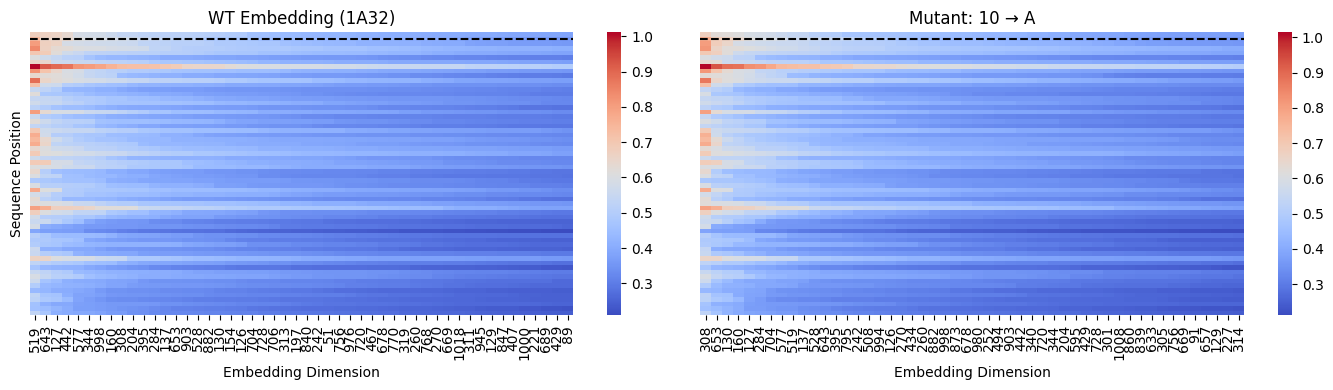

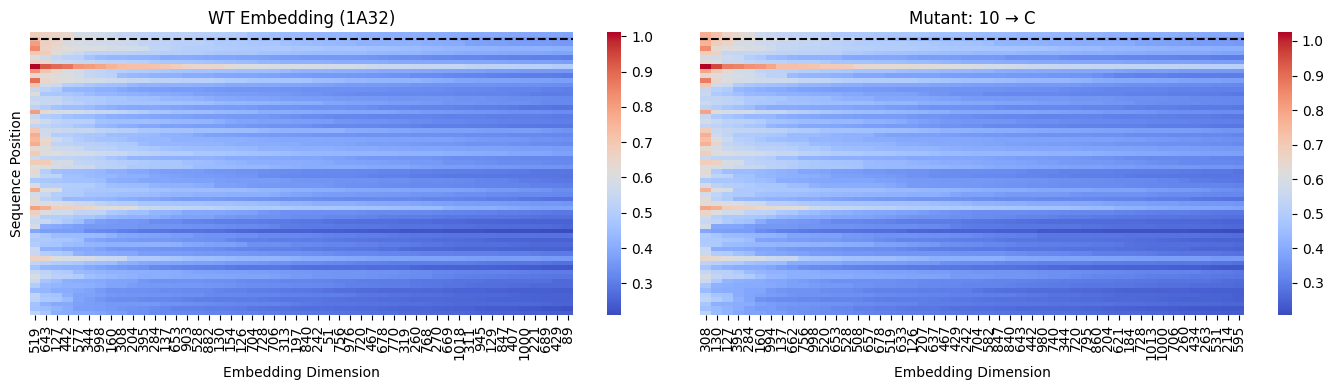

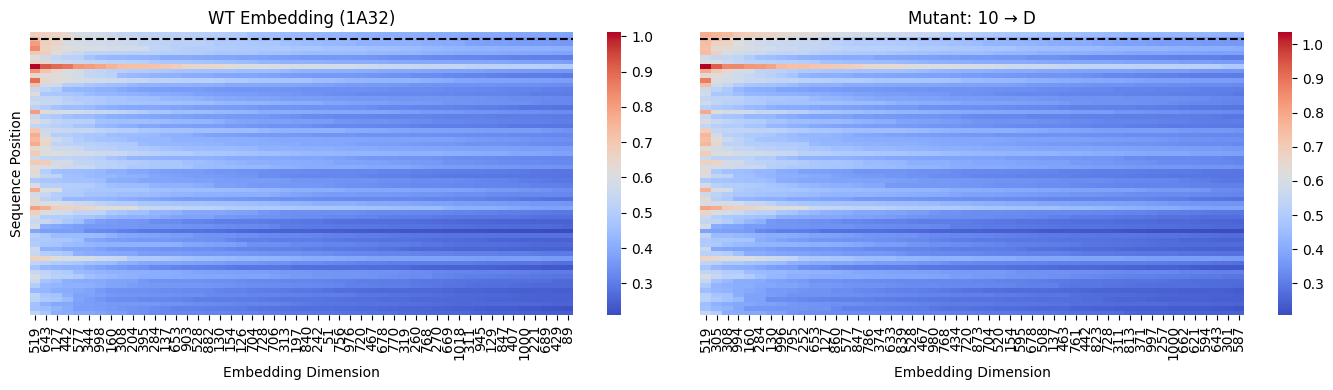

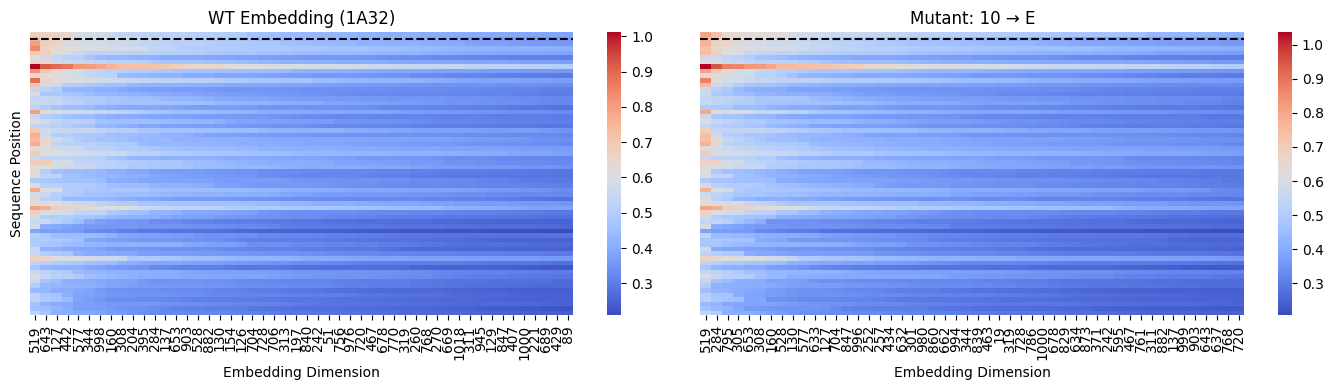

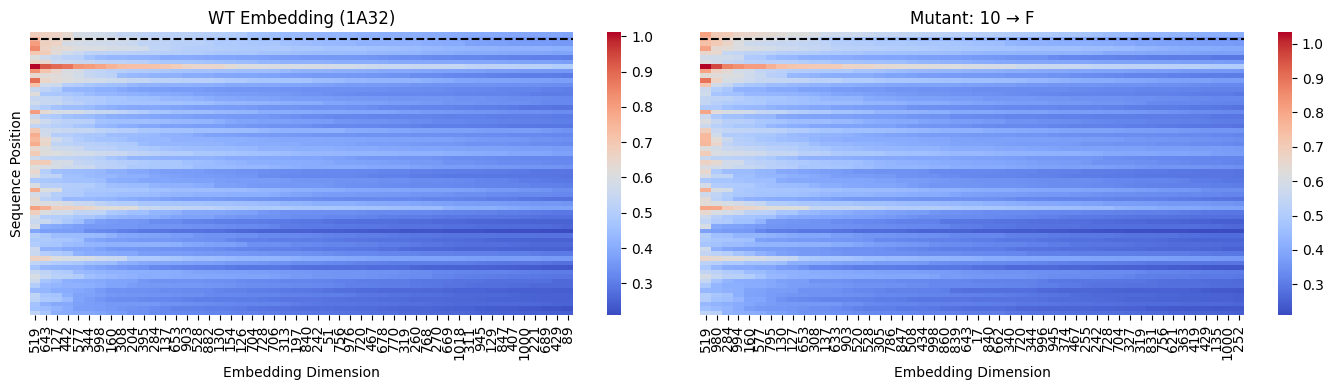

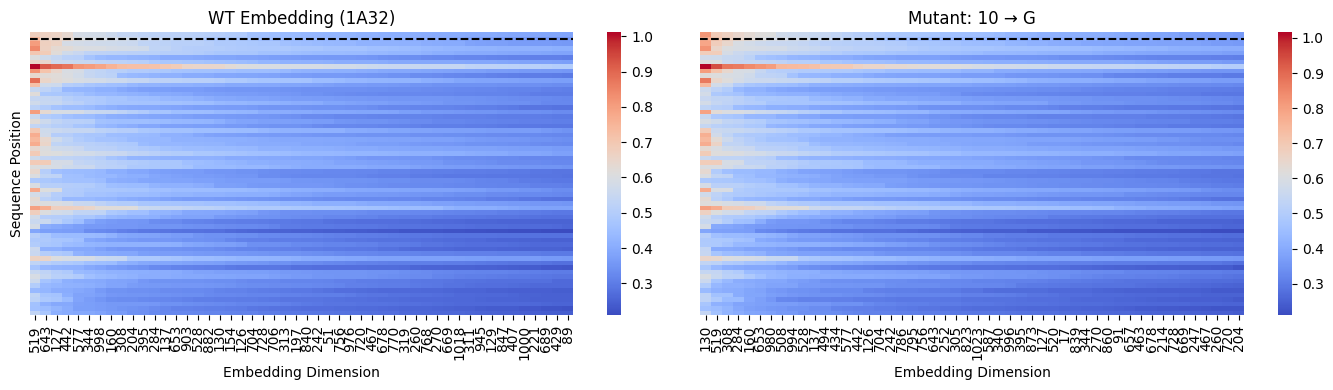

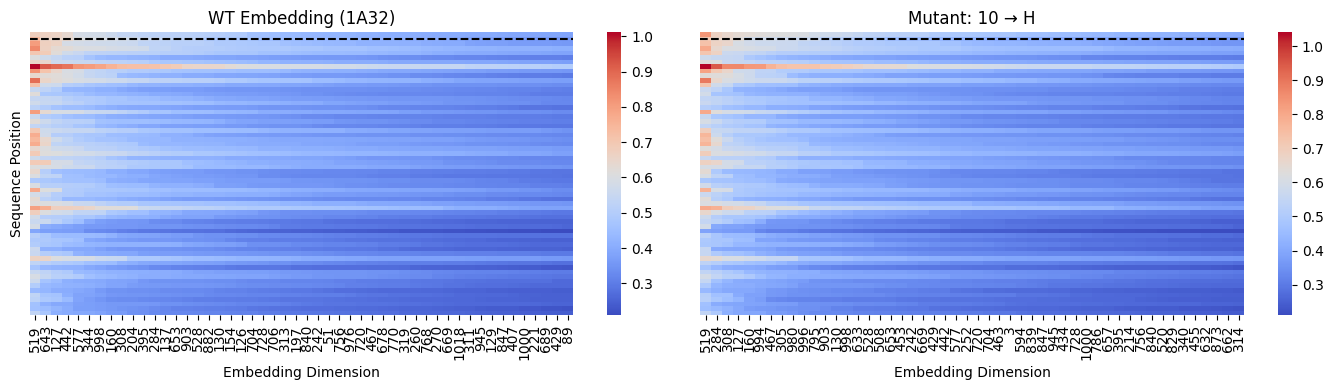

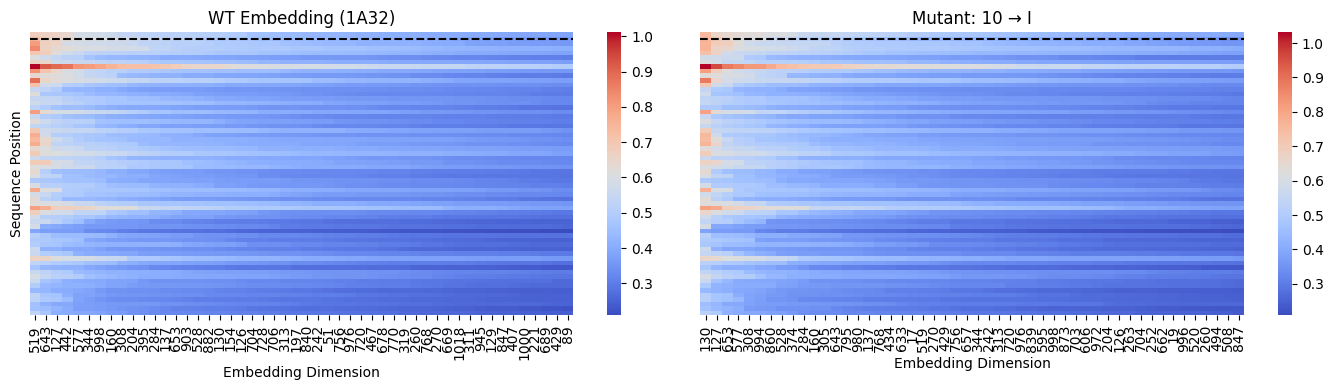

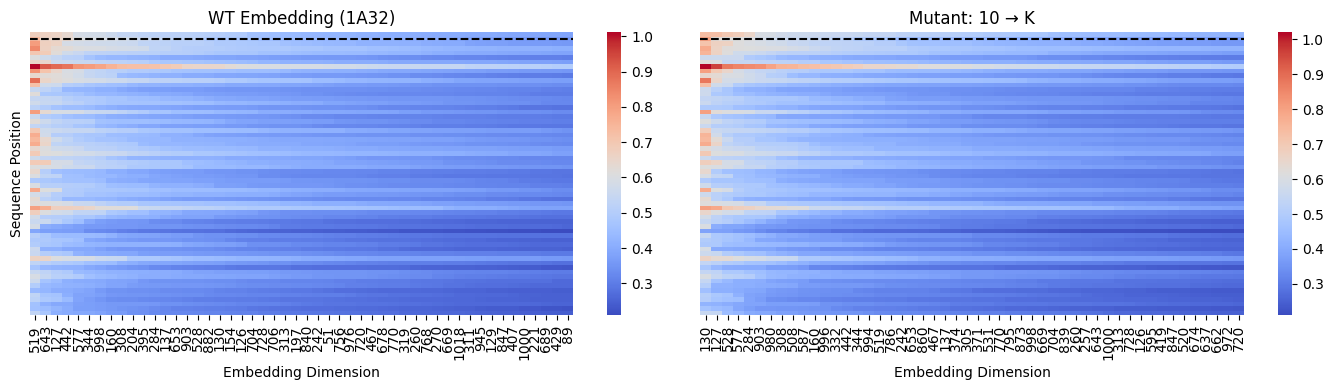

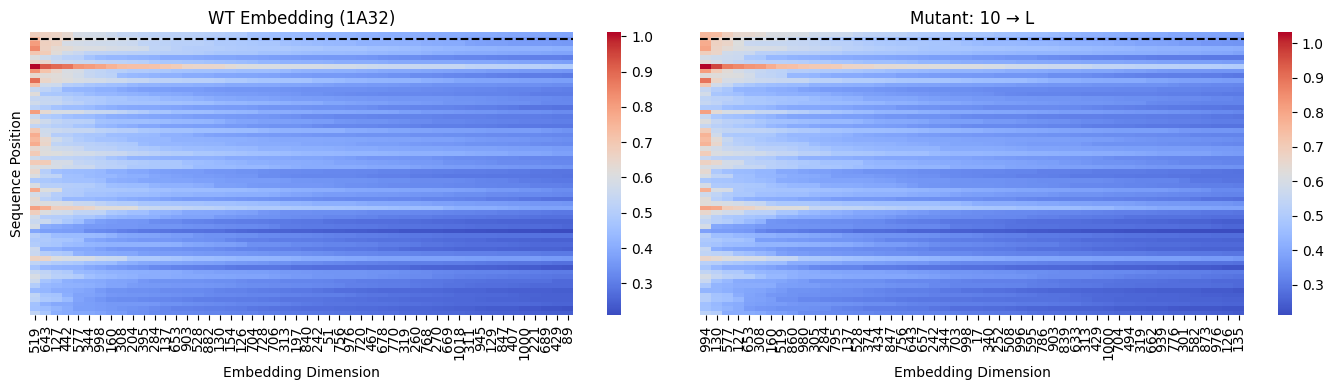

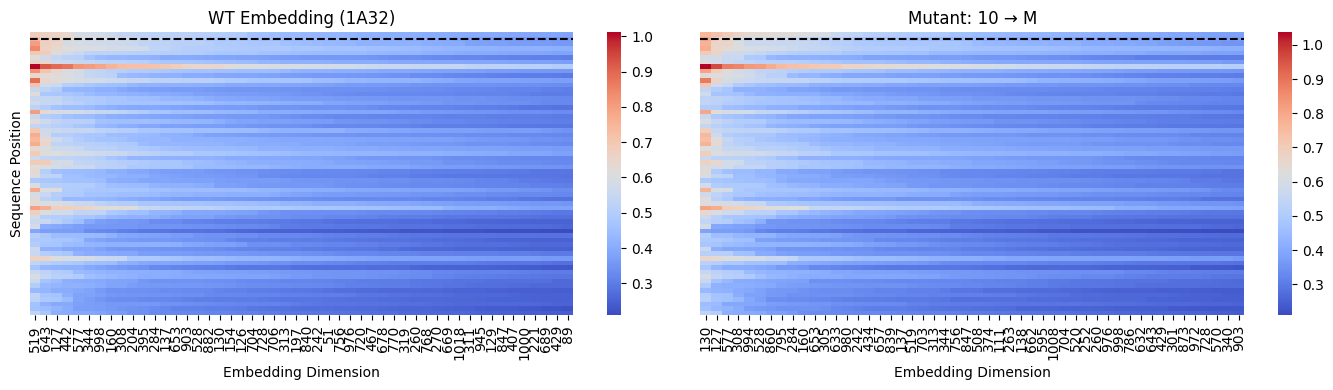

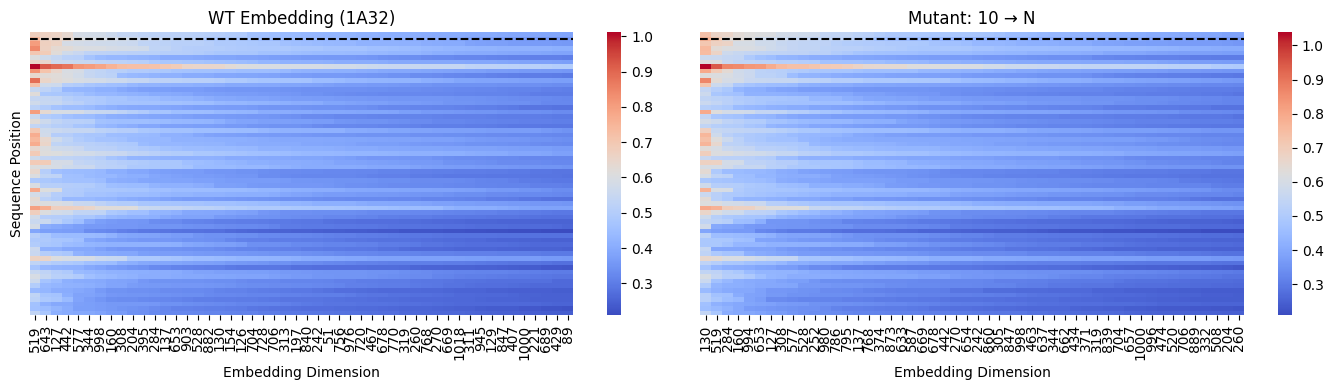

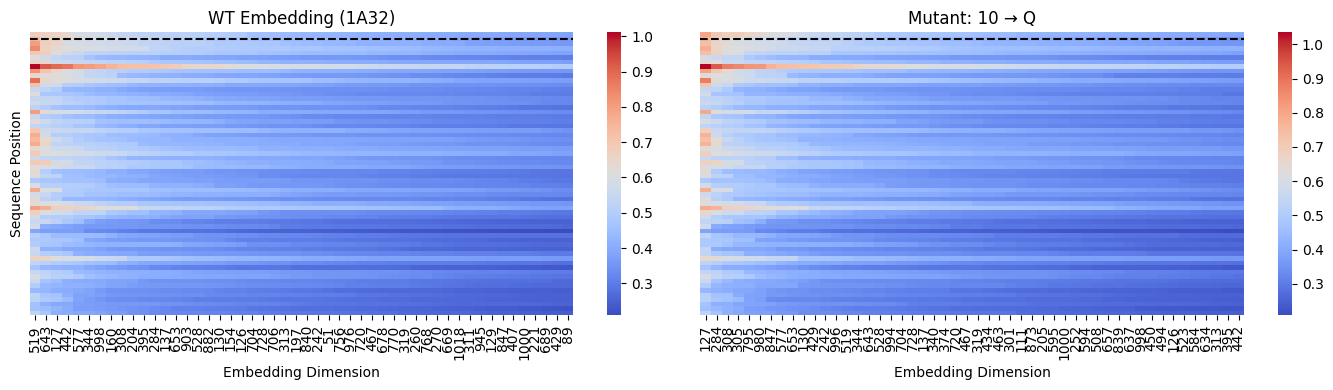

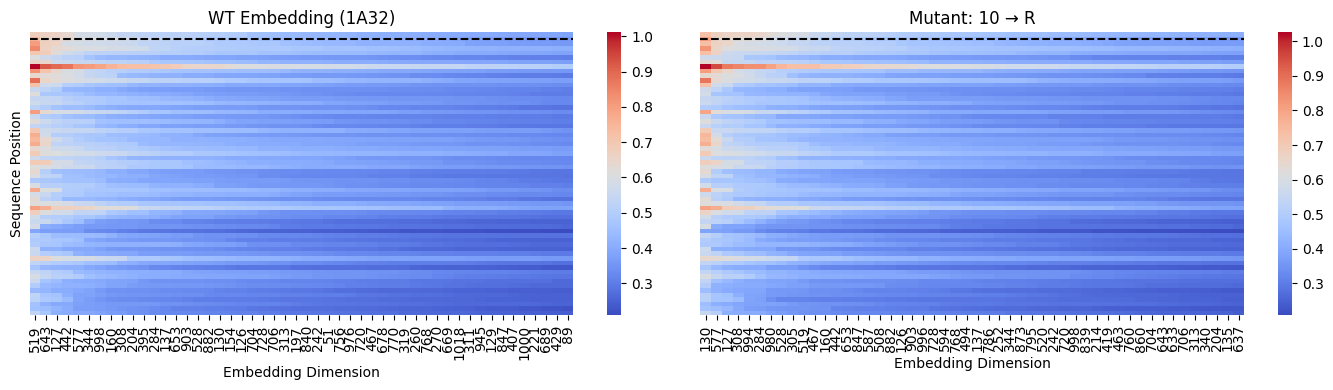

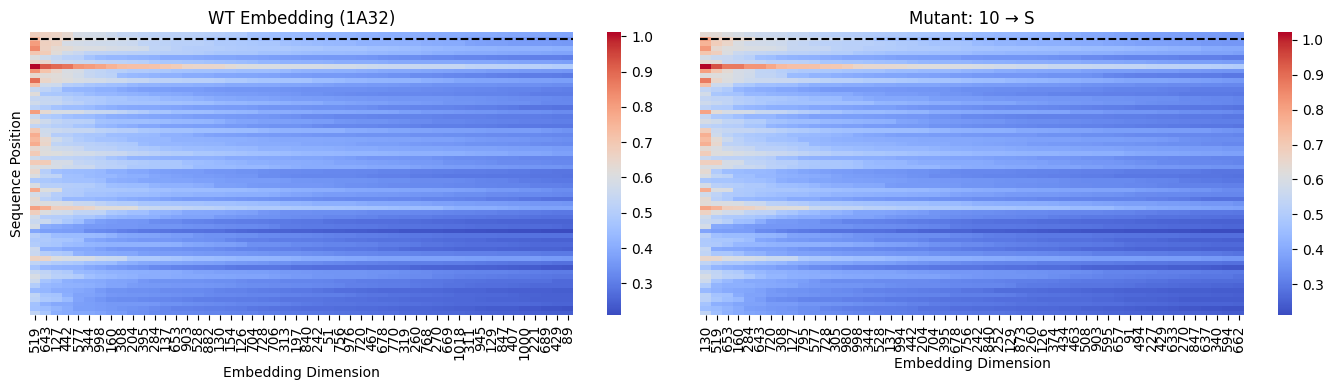

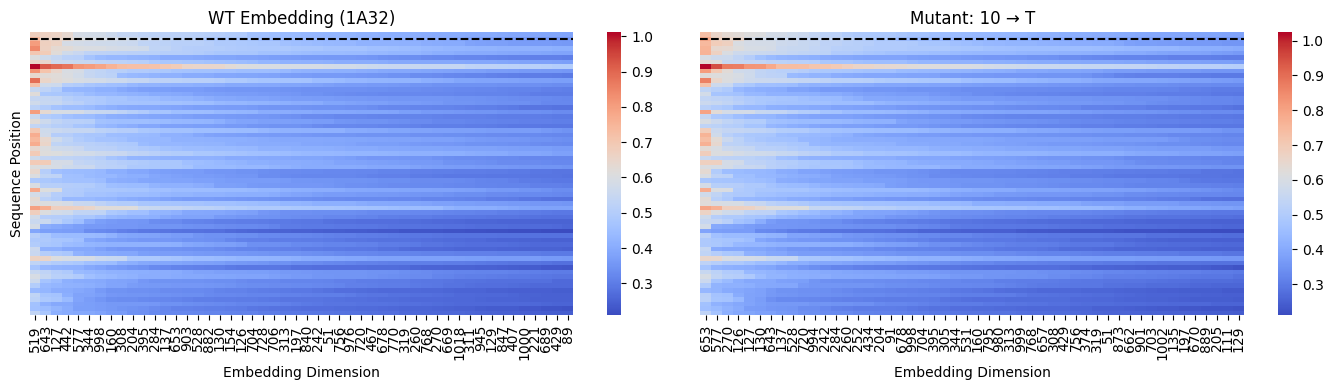

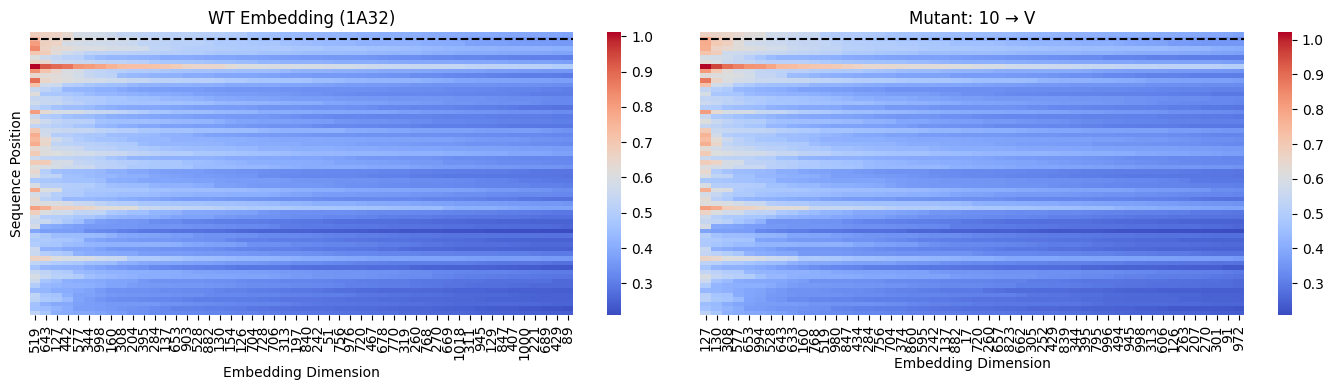

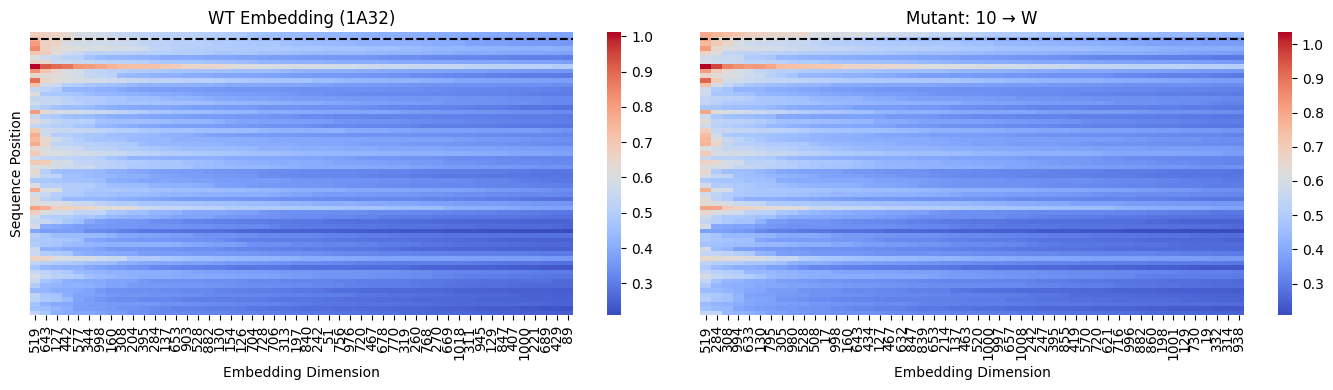

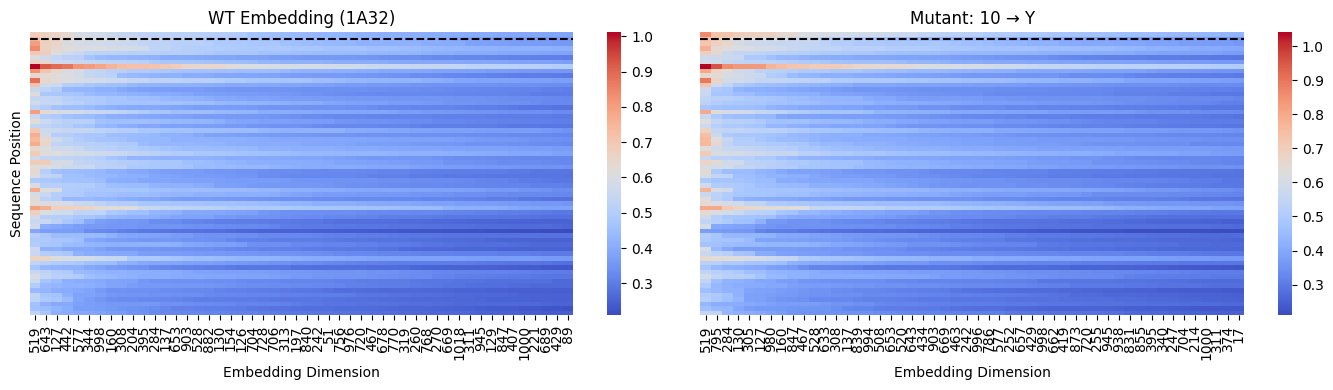

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load WT values and dimension indices
wt_vals = np.load("1A32_wildtype_maxpool_embedding.npy")  # (L, 50)
with open("1A32_wildtype_maxpool_dimensions.pkl", "rb") as f:
    wt_dims = pickle.load(f)  # (L, 50)

#  Load mutation data
with open("1A32_mutations_maxpool_embeddings.pkl", "rb") as f:
    mutations = pickle.load(f)

# Set target position
position_to_plot = 2  # 1-based
position_index = position_to_plot - 1  # 0-based

#  Plot per mutation
for mutant_aa, data in mutations[position_to_plot].items():
    mut_vals = data["values"]  # shape (L, 50)
    mut_dims = data["dims"]    # shape (L, 50)

    # === Plot
    fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    sns.heatmap(wt_vals, cmap="coolwarm", ax=axs[0], cbar=True,
                xticklabels=wt_dims[0], yticklabels=5)
    axs[0].set_title("WT Embedding (1A32)")
    axs[0].set_xlabel("Embedding Dimension")
    axs[0].set_ylabel("Sequence Position")
    axs[0].axhline(position_index + 0.5, color='black', linestyle='--')

    sns.heatmap(mut_vals, cmap="coolwarm", ax=axs[1], cbar=True,
                xticklabels=mut_dims[0], yticklabels=False)
    axs[1].set_title(f"Mutant: 10 → {mutant_aa}")
    axs[1].set_xlabel("Embedding Dimension")
    axs[1].axhline(position_index + 0.5, color='black', linestyle='--')

    for ax in axs:
        ax.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()


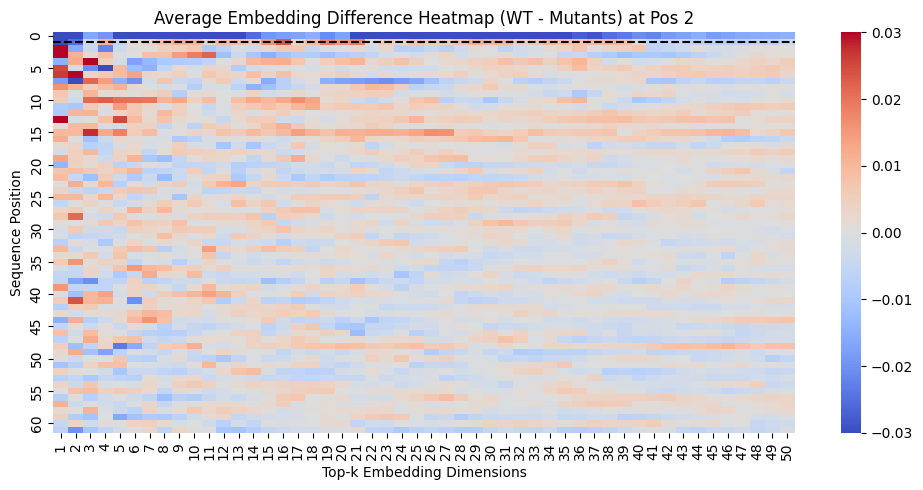

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#  Target mutation position
position_to_plot = 2
position_index = position_to_plot - 1

#  Initialize accumulator
diff_sum = None
num_mutants = 0

# Loop through all mutations at this position
for mutant_aa, data in mutations[position_to_plot].items():
    mut_vals = data["values"]  # shape: (L, 50)

    # Compute difference
    diff_vals = wt_vals - mut_vals  # shape: (L, 50)

    # Accumulate
    if diff_sum is None:
        diff_sum = diff_vals.copy()
    else:
        diff_sum += diff_vals
    num_mutants += 1

# Average the differences
avg_diff = diff_sum / num_mutants  # shape: (L, 50)

#Plot with fixed color scale range [-0.1, 0.1]
plt.figure(figsize=(10, 5))
sns.heatmap(avg_diff, cmap="coolwarm", center=0,
            vmin=-0.03, vmax=0.03,
            xticklabels=np.arange(1, 51), yticklabels=5)
plt.title(f"Average Embedding Difference Heatmap (WT - Mutants) at Pos {position_to_plot}")
plt.xlabel("Top-k Embedding Dimensions")
plt.ylabel("Sequence Position")
plt.axhline(position_index + 0.5, color='black', linestyle='--')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


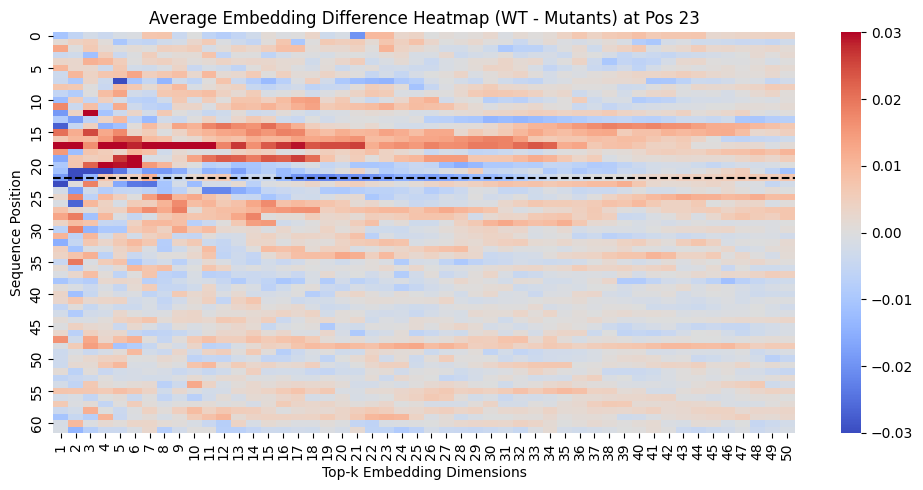

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Target mutation position
position_to_plot = 23
position_index = position_to_plot - 1

# Initialize accumulator
diff_sum = None
num_mutants = 0

#  Loop through all mutations at this position
for mutant_aa, data in mutations[position_to_plot].items():
    mut_vals = data["values"]  # shape: (L, 50)

    # Compute difference
    diff_vals = wt_vals - mut_vals  # shape: (L, 50)

    # Accumulate
    if diff_sum is None:
        diff_sum = diff_vals.copy()
    else:
        diff_sum += diff_vals
    num_mutants += 1

# Average the differences
avg_diff = diff_sum / num_mutants  # shape: (L, 50)

#  Plot with fixed color scale range [-0.1, 0.1]
plt.figure(figsize=(10, 5))
sns.heatmap(avg_diff, cmap="coolwarm", center=0,
            vmin=-0.03, vmax=0.03,
            xticklabels=np.arange(1, 51), yticklabels=5)
plt.title(f"Average Embedding Difference Heatmap (WT - Mutants) at Pos {position_to_plot}")
plt.xlabel("Top-k Embedding Dimensions")
plt.ylabel("Sequence Position")
plt.axhline(position_index + 0.5, color='black', linestyle='--')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


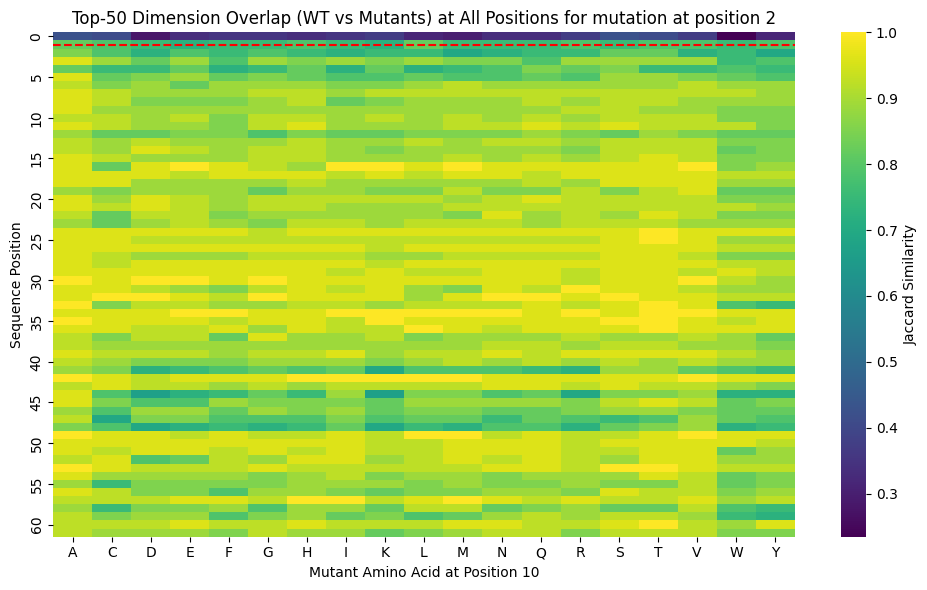

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setu
position_to_plot = 2
position_index = position_to_plot - 1
mutant_aas = list(mutations[position_to_plot].keys())

# Create array to store Jaccard values: shape (L, #mutants)
L = len(wt_dims)  # number of sequence positions
jaccard_matrix = np.zeros((L, len(mutant_aas)))

# Compute Jaccard similarity at each position
for i in range(L):
    wt_dim_set = set(wt_dims[i])
    for j, aa in enumerate(mutant_aas):
        mut_dims_i = set(mutations[position_to_plot][aa]["dims"][i])
        jaccard_score = len(wt_dim_set & mut_dims_i) / len(wt_dim_set | mut_dims_i)
        jaccard_matrix[i, j] = jaccard_score

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(jaccard_matrix, cmap="viridis", xticklabels=mutant_aas, yticklabels=5,
            cbar_kws={"label": "Jaccard Similarity"})
plt.title(f"Top-50 Dimension Overlap (WT vs Mutants) at All Positions for mutation at position 2")
plt.xlabel("Mutant Amino Acid at Position 10")
plt.ylabel("Sequence Position")
plt.axhline(position_index + 0.5, color='red', linestyle='--', label="Mutation Site")
plt.tight_layout()
plt.show()


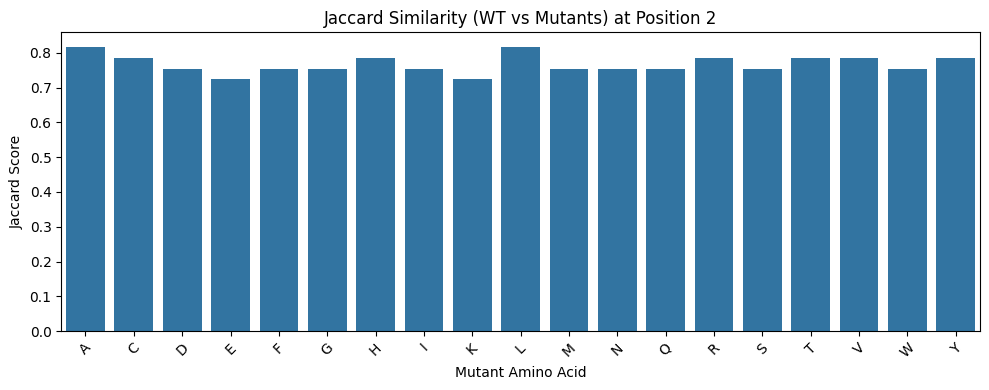

In [ ]:
# Only for position 10
wt_dim_set = set(wt_dims[position_index])
jaccard_scores = []

for aa in mutant_aas:
    mut_dims_set = set(mutations[position_to_plot][aa]["dims"][position_index])
    score = len(wt_dim_set & mut_dims_set) / len(wt_dim_set | mut_dims_set)
    jaccard_scores.append(score)

# Bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x=mutant_aas, y=jaccard_scores)
plt.title("Jaccard Similarity (WT vs Mutants) at Position 2")
plt.ylabel("Jaccard Score")
plt.xlabel("Mutant Amino Acid")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


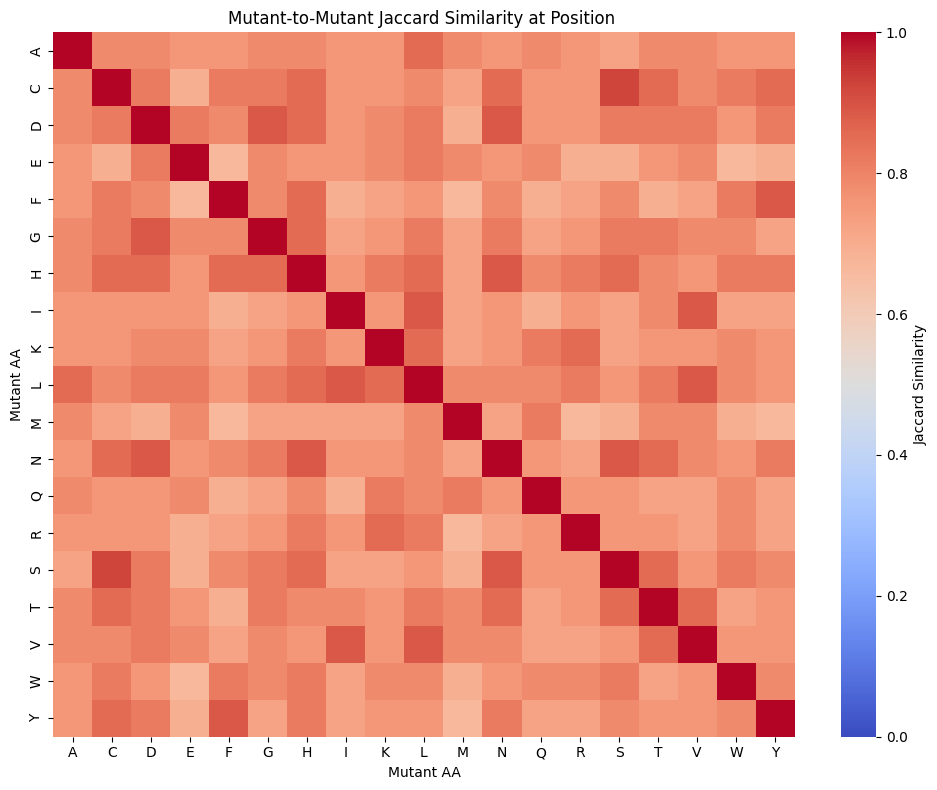

In [ ]:
# Create a 19 x 19 matrix
n = len(mutant_aas)
jaccard_matrix = np.zeros((n, n))

for i, aa1 in enumerate(mutant_aas):
    dims1 = set(mutations[position_to_plot][aa1]["dims"][position_index])
    for j, aa2 in enumerate(mutant_aas):
        dims2 = set(mutations[position_to_plot][aa2]["dims"][position_index])
        jaccard_matrix[i, j] = len(dims1 & dims2) / len(dims1 | dims2)

# Plot full similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_matrix, annot=False, xticklabels=mutant_aas, yticklabels=mutant_aas,
            cmap="coolwarm", vmin=0, vmax=1, cbar_kws={"label": "Jaccard Similarity"})
plt.title("Mutant-to-Mutant Jaccard Similarity at Position ")
plt.xlabel("Mutant AA")
plt.ylabel("Mutant AA")
plt.tight_layout()
plt.show()


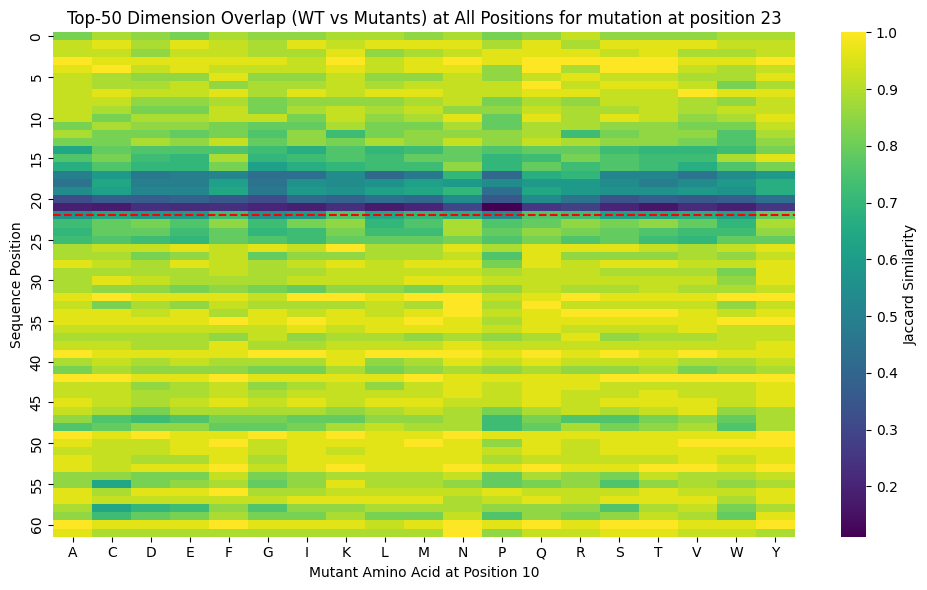

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
position_to_plot = 40
position_index = position_to_plot - 1
mutant_aas = list(mutations[position_to_plot].keys())

# Create array to store Jaccard values: shape (L, #mutants)
L = len(wt_dims)  # number of sequence positions
jaccard_matrix = np.zeros((L, len(mutant_aas)))

# Compute Jaccard similarity at each position
for i in range(L):
    wt_dim_set = set(wt_dims[i])
    for j, aa in enumerate(mutant_aas):
        mut_dims_i = set(mutations[position_to_plot][aa]["dims"][i])
        jaccard_score = len(wt_dim_set & mut_dims_i) / len(wt_dim_set | mut_dims_i)
        jaccard_matrix[i, j] = jaccard_score

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(jaccard_matrix, cmap="viridis", xticklabels=mutant_aas, yticklabels=5,
            cbar_kws={"label": "Jaccard Similarity"})
plt.title(f"Top-50 Dimension Overlap (WT vs Mutants) at All Positions for mutation at position 23")
plt.xlabel("Mutant Amino Acid at Position 10")
plt.ylabel("Sequence Position")
plt.axhline(position_index + 0.5, color='red', linestyle='--', label="Mutation Site")
plt.tight_layout()
plt.show()


In [ ]:
# Only for position 10
wt_dim_set = set(wt_dims[position_index])
jaccard_scores = []

for aa in mutant_aas:
    mut_dims_set = set(mutations[position_to_plot][aa]["dims"][position_index])
    score = len(wt_dim_set & mut_dims_set) / len(wt_dim_set | mut_dims_set)
    jaccard_scores.append(score)

# Bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x=mutant_aas, y=jaccard_scores)
plt.title("Jaccard Similarity (WT vs Mutants) at Position 23")
plt.ylabel("Jaccard Score")
plt.xlabel("Mutant Amino Acid")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'wt_dims' is not defined

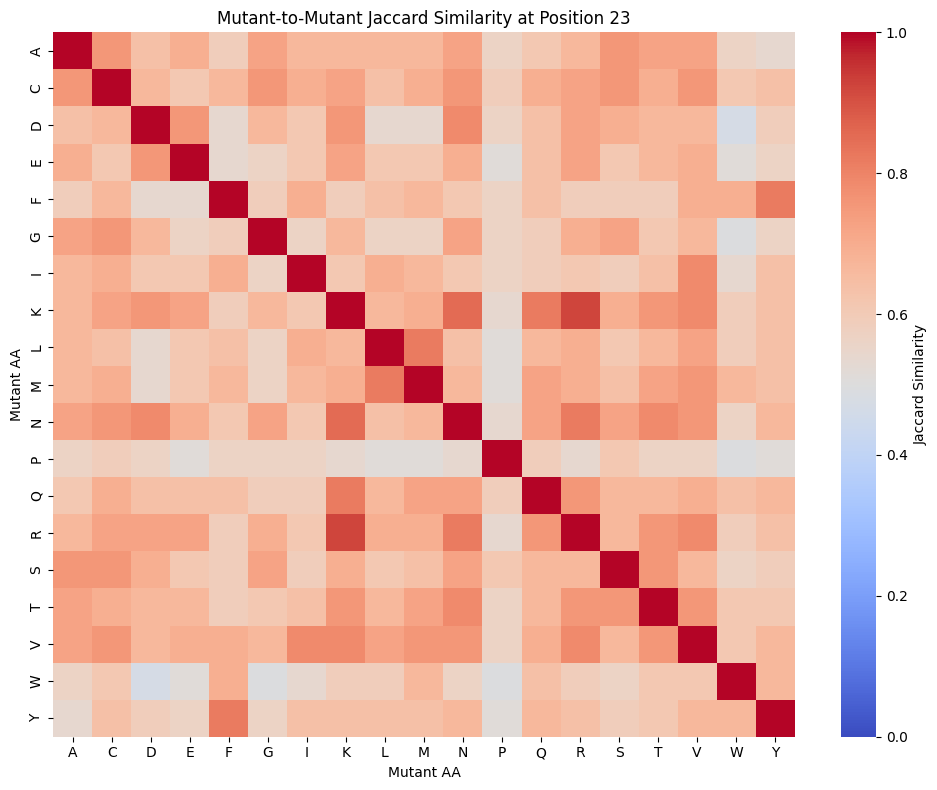

In [ ]:
# Create a 19 x 19 matrix
n = len(mutant_aas)
jaccard_matrix = np.zeros((n, n))

for i, aa1 in enumerate(mutant_aas):
    dims1 = set(mutations[position_to_plot][aa1]["dims"][position_index])
    for j, aa2 in enumerate(mutant_aas):
        dims2 = set(mutations[position_to_plot][aa2]["dims"][position_index])
        jaccard_matrix[i, j] = len(dims1 & dims2) / len(dims1 | dims2)

# Plot full similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_matrix, annot=False, xticklabels=mutant_aas, yticklabels=mutant_aas,
            cmap="coolwarm", vmin=0, vmax=1, cbar_kws={"label": "Jaccard Similarity"})
plt.title("Mutant-to-Mutant Jaccard Similarity at Position 23")
plt.xlabel("Mutant AA")
plt.ylabel("Mutant AA")
plt.tight_layout()
plt.show()
